# Méthode LDA 

In [1]:
%matplotlib inline
from nuscenes.nuscenes import NuScenes
nusc = NuScenes(version='v1.0-mini', dataroot='/Users/tiffanydarini/nuscenes-devkit/python-sdk/tutorials/data/sets/nuscenes/v1.0-mini', verbose=True)

Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.314 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


### Fonction utiles et imports nécessaires

In [2]:
# Fonction qui renvoie les tables ego_pose d'une scène donnée
def get_poses(scene_token):
    pose_list = []
    scene_rec = nusc.get('scene', scene_token)
    sample_rec = nusc.get('sample', scene_rec['first_sample_token'])
    sd_rec = nusc.get('sample_data', sample_rec['data']['LIDAR_TOP'])
    
    ego_pose = nusc.get('ego_pose', sd_rec['token'])
    pose_list.append(ego_pose)

    while sd_rec['next'] != '':
        sd_rec = nusc.get('sample_data', sd_rec['next'])
        ego_pose = nusc.get('ego_pose', sd_rec['token'])
        pose_list.append(ego_pose)

    return pose_list

In [3]:
# On crée une fonction qui renvoie la liste des rangs dans les listes X,Y des objets immobiles de 
# cette liste et donc d'une même catégorie, ainsi que la liste des objets mobiles 
from math import sqrt

def immobile(X,Y):
    Immo = []
    Mobile = []
    n = len(X) # Nombre d'élément dans la catégorie 
    for i in range(0,n-1):
        X_coord = X[i]
        Y_coord = Y[i]
        if len(X_coord)==1 :
            Immo.append(i)
        else : 
            d = 0 
            for k in range(0,len(X_coord)-1):
                d+= sqrt((X_coord[k+1]-X_coord[k])**2+(Y_coord[k+1]-Y_coord[k])**2)
            if d<2 : # Si la distance totale parcourue par l'objet est inférieur à 2m, on considère que l'objet bouge pas
                Immo.append(i)
            else :
                Mobile.append(i)
    return Immo,Mobile  

In [4]:
from dtw import *
import matplotlib.pyplot as plt
from datetime import timedelta

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [5]:
import numpy as np 
from math import sqrt 

# Fonction qui renvoie la matrice des distances 
def Matrice_distance(X_ego,Y_ego,X_veh,Y_veh):
    M = np.zeros((len(X_veh),len(X_ego)))
    for i in range(0,len(X_veh)):
        for j in range(0,len(X_ego)):
            #M[i,j] = sqrt((X_veh[len(X_veh)-1-i]-X_ego[j])**2+(Y_veh[len(Y_veh)-1-i]-Y_ego[j])**2)
            M[i,j] = sqrt((X_veh[i]-X_ego[j])**2+(Y_veh[i]-Y_ego[j])**2)
    return M 
     

In [6]:
import numpy as np 
from math import sqrt 

# Fonction qui renvoie la matrice des distances entre 
# les pts qui interagissent dans le temps 

def M_distance_time(X_ego,Y_ego,T_ego,X_veh,Y_veh,T_veh):
    
    debut = max(T_ego[0],T_veh[0]) # Temps début detection vehicule 1 
    fin = min(T_ego[len(T_ego)-1],T_veh[len(T_veh)-1]) # Temps fin detection vehicule 1 

    # On va créer la liste des indices des élements du veh 1 qui sont en même temps que le veh 2
    L_indice_ego = []
    for k in range(0,len(T_ego)):
        if debut<=T_ego[k]<=fin:
            L_indice_ego.append(k)
            
    # Pareil pour le veh 
    L_indice_veh = []
    for k in range(0,len(T_veh)):
        if debut<=T_veh[k]<=fin:
            L_indice_veh.append(k)
    
    M = np.zeros((len(L_indice_veh),len(L_indice_ego)))
    for i in range(0,len(L_indice_veh)):
        for j in range(0,len(L_indice_ego)):
            M[i,j] = sqrt((X_veh[L_indice_veh[i]]-X_ego[L_indice_ego[j]])**2+(Y_veh[L_indice_veh[i]]-Y_ego[L_indice_ego[j]])**2)
    
    return M 

In [7]:
# Pour normaliser le calcul de DTW, on va créer une fonction qui calcule
# la distance parcourue par un véhicule au cours de la scène, en prenant
# en entrée ses coordonnées

def distance_parcourue(X,Y,Z):
    D =[0]
    for k in range(0,len(X)-1):
        d = D[k]+ sqrt((X[k+1]-X[k])**2+(Y[k+1]-Y[k])**2+(Z[k+1]-Z[k])**2)
        D.append(d)
    return D[len(D)-1]

#### Fenêtre glissante

In [8]:
## Fonction qui renvoie une dataframe avec les valeurs de dtw calculés sur des intervalles de temps d'une seconde : 

#imports nécessaires
import matplotlib.pyplot as plt
from math import sqrt
import datetime 
from datetime import timedelta
from dtw import *
import pandas as pd

def dtw_glissante(scene_name):
    
    # On crée une dataframe 
    df = pd.DataFrame()
    L_intervalle = [[k,k+1] for k in range(0,20)]
    df['index']= L_intervalle
    df.set_index('index',inplace=True)
    df.index.name = None
    
    scene_token = nusc.field2token('scene','name',scene_name)[0]
    sample_token = nusc.field2token('sample','scene_token',scene_token)# Ensemble des token des échantillons de la scene 
    
    # Pour tracer la trajectoire du véhicule ego
    Liste_ego_poses = get_poses(scene_token) 
    X_coord =[]
    Y_coord =[]
    Z_coord =[]
    T_timestamp = [] # liste des timestamps
    for k in range(0,len(Liste_ego_poses)):
        X_coord.append(Liste_ego_poses[k]['translation'][0])
        Y_coord.append(Liste_ego_poses[k]['translation'][1])
        Z_coord.append(Liste_ego_poses[k]['translation'][2])
        T_timestamp.append(Liste_ego_poses[k]['timestamp'])
        
    # Ensemble des sample_annotation de la scène :
    sample_annotation_token = []
    for k in sample_token : 
        L = nusc.field2token('sample_annotation','sample_token',k)
        sample_annotation_token = sample_annotation_token + L
    
    # On créé la liste des token des instances présents dans les sample_annotation
    L_instance_token = []
    for k in sample_annotation_token :
        exemple = nusc.get('sample_annotation', k)
        L_instance_token.append(exemple['instance_token'])
    # Puisque pour un même objet, on peut avoir plusieurs annotations, on supprime les doublons de L
    L_instance_token = list(set(L_instance_token))
    
    # Liste des catégories d'objet dans la scène 
    L_category_name = []
    for k in sample_annotation_token :
        exemple = nusc.get('sample_annotation', k)
        L_category_name.append(exemple['category_name'])
    L_category_name = list(set(L_category_name)) #on supprime les doublons 
   
    L_vehicule = ['vehicle.bicycle','vehicle.bus.bendy','vehicle.bus.rigid','vehicle.car','vehicle.construction','vehicle.emergency.ambulance','vehicle.emergency.police','vehicle.motorcycle','vehicle.trailer','vehicle.truck']
    
    L_category_name = [k for k in L_category_name if k in L_vehicule]
    
    # Boucle sur chaque catégorie trouvée
    for j in range(0,len(L_category_name)):   
        catego_name = L_category_name[j]
        catego_token = nusc.field2token('category','name',catego_name)
        category = nusc.get('category',catego_token[0])

        # Ensemble des instances appartenant à la fois à la scène et à la catégorie
        L_instance_category = nusc.field2token('instance','category_token',catego_token[0]) # instance dans la catégorie
        L_instance_category = [x for x in L_instance_category if x in L_instance_token]# et dans la scène 
        L_instance_category
        
        # Il peut y avoir plusieurs éléments de la catégorie dans la scène, ici chaque ligne de L représente 
        # les token des sample_annotation pour un élément de cette catégorie. 

        L=[]
        for k in L_instance_category : 
            instance_category = nusc.get('instance',k)
            nbr_annotations = instance_category['nbr_annotations']
            if nbr_annotations == 1:
                L.append([instance_category['first_annotation_token']])
            else : 
                H = []
                first_token = instance_category['first_annotation_token']
                last_token = instance_category['last_annotation_token']
                current_token = first_token 
        
                s = 0 
                while s!= nbr_annotations :
                    current_ann = nusc.get('sample_annotation', current_token)
                    H.append(current_ann['token'])
                    current_token = current_ann['next'] #On passe au suivant
                    s+=1
                L.append(H)
        
        # Maintenant qu'on a les token de tous les sample_annotation pour tous les éléments d'une même catégorie, 
        # on va pouvoir récupérer leurs positions et tracer leurs trajectoires

        X = []
        Y = []
        Z = []
        T_time = []
        for k in L :
            x = []
            y = []
            z = []
            t=[]
            for j in k :
                sample_annotation = nusc.get('sample_annotation',j)
                x.append(sample_annotation['translation'][0])
                y.append(sample_annotation['translation'][1])
                z.append(sample_annotation['translation'][2])
                t.append(nusc.get('sample',sample_annotation['sample_token'])['timestamp'])
            X.append(x)
            Y.append(y)
            Z.append(z)
            T_time.append(t)
    
        # On crée les listes des objets immobiles et mobiles de la catégorie
        Immo, Mobile = immobile(X,Y)
        
        # On conserve uniquement les objets mobiles 
        X_mobile=[X[i] for i in Mobile]
        Y_mobile=[Y[i] for i in Mobile]
        Z_mobile=[Z[i] for i in Mobile]
        T_mobile = [T_time[i] for i in Mobile]
        
        if len(X_mobile)>0:
        
            for i in range(0,len(X_mobile)):
            
                L_df = []
                # On fait une boucle sur les intervalles de temps 
                for k in range(0,20):
                    current_intervalle = [k,k+1]
                    # On crée les listes des coordonnées qu'on va garder ie qui sont dans l'intervalle de temps ci-dessus
                    Lx_pt_veh = []
                    Ly_pt_veh = []
                    Lt_pt_veh = []
                    Lx_pt_ego = []
                    Ly_pt_ego = []
                    Lt_pt_ego = []
                
                    # On remplit avec les pts du véhicule dont le timestamp est dans l'intervalle 
                    for s in range(len(X_mobile[i])):
                        tveh = (datetime.datetime.fromtimestamp(T_mobile[i][s]/1e6)-datetime.datetime.fromtimestamp(T_timestamp[0]/ 1e6)).total_seconds()
                        if tveh <= current_intervalle[1] and tveh >= current_intervalle[0] :
                            Lx_pt_veh.append(X_mobile[i][s])
                            Ly_pt_veh.append(Y_mobile[i][s])
                            Lt_pt_veh.append(T_mobile[i][s])
                    
                
                
                    # On remplit avec les pts du véhicule ego dont le timestamp est dans l'intervalle 
                    for s in range(len(X_coord)):
                        tego = (datetime.datetime.fromtimestamp(T_timestamp[s]/1e6)-datetime.datetime.fromtimestamp(T_timestamp[0]/ 1e6)).total_seconds()
                        if tego <= current_intervalle[1] and tego >= current_intervalle[0]:
                            Lx_pt_ego.append(X_coord[s])
                            Ly_pt_ego.append(Y_coord[s])
                            Lt_pt_ego.append(T_timestamp[s])
                
                            
                    if len(Lx_pt_veh)==0:
                        L_df.append(np.nan)
                    else :
                        #M_distance = M_distance_time(Lx_pt_ego,Ly_pt_ego,Lt_pt_ego,Lx_pt_veh,Ly_pt_veh,Lt_pt_veh)
                        M_distance = Matrice_distance(Lx_pt_ego,Ly_pt_ego,Lx_pt_veh,Ly_pt_veh)
                        alignment = dtw(M_distance)
                        distance = alignment.normalizedDistance
                        L_df.append(distance) 


                nom = catego_name +' '+str(i+1)
                df[nom]= L_df
    
    return df

#M_distance_time(X_coord,Y_coord,T_timestamp,X_mobile[i],Y_mobile[i],T_mobile[i])

#### Produit scalaire entre les vecteurs

In [9]:
# Fonction qui renvoie la matrice des produits scalaires
import numpy as np

def Matrice_produit_scalaire(X_coord,Y_coord,T_timestamp,X_veh,Y_veh,T_veh):
    
        
    debut = max(T_timestamp[0],T_veh[0]) # Temps début detection vehicule 1 
    fin = min(T_timestamp[len(T_timestamp)-1],T_veh[len(T_veh)-1]) # Temps fin detection vehicule 1 

    # On va créer la liste des indices des élements du veh 1 qui sont en même temps que le veh 2
    L_indice_ego = []
    for k in range(0,len(T_timestamp)):
        if debut<=T_timestamp[k]<=fin:
            L_indice_ego.append(k)
            
    # Pareil pour le veh 
    L_indice_veh = []
    for k in range(0,len(T_veh)):
        if debut<=T_veh[k]<=fin:
            L_indice_veh.append(k)
    
    # On crée la liste des vecteurs pour le véhicule ego avec les points qu'on peut garder
    V_ego = []
    for k in range(0,len(L_indice_ego)-1):
        t2 = datetime.datetime.fromtimestamp(T_timestamp[L_indice_ego[k+1]]/ 1e6)
        t1 = datetime.datetime.fromtimestamp(T_timestamp[L_indice_ego[k]]/ 1e6)
        t = (t2-t1).total_seconds()
        v = np.array([X_coord[L_indice_ego[k+1]]-X_coord[L_indice_ego[k]],Y_coord[L_indice_ego[k+1]]-Y_coord[L_indice_ego[k]]])/t # Le vecteur a pour norme la vitesse à l'instant k
        V_ego.append(v)
        
        
    # On crée la liste des vecteurs pour le veh avec les points qu'on peut garder
    V = []
    for k in range(0,len(L_indice_veh)-1):
        t2 = datetime.datetime.fromtimestamp(T_veh[L_indice_veh[k+1]]/ 1e6)
        t1 = datetime.datetime.fromtimestamp(T_veh[L_indice_veh[k]]/ 1e6)
        t = (t2-t1).total_seconds()
        v = np.array([X_veh[L_indice_veh[k+1]]-X_veh[L_indice_veh[k]],Y_veh[L_indice_veh[k+1]]-Y_veh[L_indice_veh[k]]])/t
        V.append(v)
        
    # On crée la matrice des produits scalaires : 
    M = np.zeros((len(V),len(V_ego)))
    for i in range(0,len(V)):
        for j in range(0,len(V_ego)):
            M[i,j] = np.dot(V[i],V_ego[j])/(np.linalg.norm(V[i])*np.linalg.norm(V_ego[j]))
    return M 

In [10]:
# Fonction qui renvoie la norme du produit vectoriel divisée par la norme des vecteurs

def Matrice_produit_vectoriel(X_coord,Y_coord,T_timestamp,X_veh,Y_veh,T_veh):
    
         
    debut = max(T_timestamp[0],T_veh[0]) # Temps début detection vehicule 1 
    fin = min(T_timestamp[len(T_timestamp)-1],T_veh[len(T_veh)-1]) # Temps fin detection vehicule 1 

    # On va créer la liste des indices des élements du veh 1 qui sont en même temps que le veh 2
    L_indice_ego = []
    for k in range(0,len(T_timestamp)):
        if debut<=T_timestamp[k]<=fin:
            L_indice_ego.append(k)
            
    # Pareil pour le veh 
    L_indice_veh = []
    for k in range(0,len(T_veh)):
        if debut<=T_veh[k]<=fin:
            L_indice_veh.append(k)
    
    # On crée la liste des vecteurs pour le véhicule ego avec les points qu'on peut garder
    V_ego = []
    for k in range(0,len(L_indice_ego)-1):
        t2 = datetime.datetime.fromtimestamp(T_timestamp[L_indice_ego[k+1]]/ 1e6)
        t1 = datetime.datetime.fromtimestamp(T_timestamp[L_indice_ego[k]]/ 1e6)
        t = (t2-t1).total_seconds()
        v = np.array([X_coord[L_indice_ego[k+1]]-X_coord[L_indice_ego[k]],Y_coord[L_indice_ego[k+1]]-Y_coord[L_indice_ego[k]]])/t # Le vecteur a pour norme la vitesse à l'instant k
        V_ego.append(v)
        
        
    # On crée la liste des vecteurs pour le veh avec les points qu'on peut garder
    V = []
    for k in range(0,len(L_indice_veh)-1):
        t2 = datetime.datetime.fromtimestamp(T_veh[L_indice_veh[k+1]]/ 1e6)
        t1 = datetime.datetime.fromtimestamp(T_veh[L_indice_veh[k]]/ 1e6)
        t = (t2-t1).total_seconds()
        v = np.array([X_veh[L_indice_veh[k+1]]-X_veh[L_indice_veh[k]],Y_veh[L_indice_veh[k+1]]-Y_veh[L_indice_veh[k]]])/t
        V.append(v)

    # On crée la matrice des produits vectoriels : 
    M = np.zeros((len(V),len(V_ego)))
    for i in range(0,len(V)):
        for j in range(0,len(V_ego)):
            M[i,j] = np.linalg.norm(np.cross(V[i],V_ego[j]))/(np.linalg.norm(V[i])*np.linalg.norm(V_ego[j]))
    return M 

In [11]:
# Fonction qui renvoie la vitesse moyenne de deux véhicules pendant le temps où ils interagissent 

def vitesse_moyenne(X_coord,Y_coord,T_timestamp,X_veh,Y_veh,T_veh):
    
    debut = max(T_timestamp[0],T_veh[0]) # Temps début detection vehicule 1 
    fin = min(T_timestamp[len(T_timestamp)-1],T_veh[len(T_veh)-1]) # Temps fin detection vehicule 1 

    # On va créer la liste des indices des élements du veh 1 qui sont en même temps que le veh 2
    L_indice_ego = []
    for k in range(0,len(T_timestamp)):
        if debut<=T_timestamp[k]<=fin:
            L_indice_ego.append(k)
            
    # Pareil pour le veh 
    L_indice_veh = []
    for k in range(0,len(T_veh)):
        if debut<=T_veh[k]<=fin:
            L_indice_veh.append(k)
    
    # On crée la liste des vecteurs pour le véhicule ego avec les points qu'on peut garder
    V_ego = []
    for k in range(0,len(L_indice_ego)-1):
        t2 = datetime.datetime.fromtimestamp(T_timestamp[L_indice_ego[k+1]]/ 1e6)
        t1 = datetime.datetime.fromtimestamp(T_timestamp[L_indice_ego[k]]/ 1e6)
        t = (t2-t1).total_seconds()
        v = np.array([X_coord[L_indice_ego[k+1]]-X_coord[L_indice_ego[k]],Y_coord[L_indice_ego[k+1]]-Y_coord[L_indice_ego[k]]])/t # Le vecteur a pour norme la vitesse à l'instant k
        V_ego.append(v)
    # Il faut créer le vecteur des normes de V_ego qui contient lui que des vecteurs 
    v_ego_moy = np.mean([np.linalg.norm(V_ego[i]) for i in range(0,len(V_ego))])
        
    # On crée la liste des vecteurs pour le veh avec les points qu'on peut garder
    V = []
    for k in range(0,len(L_indice_veh)-1):
        t2 = datetime.datetime.fromtimestamp(T_veh[L_indice_veh[k+1]]/ 1e6)
        t1 = datetime.datetime.fromtimestamp(T_veh[L_indice_veh[k]]/ 1e6)
        t = (t2-t1).total_seconds()
        v = np.array([X_veh[L_indice_veh[k+1]]-X_veh[L_indice_veh[k]],Y_veh[L_indice_veh[k+1]]-Y_veh[L_indice_veh[k]]])/t
        V.append(v)
    v_veh_moy = np.mean([np.linalg.norm(V[i]) for i in range(0,len(V))])
        
    return v_ego_moy,v_veh_moy

In [12]:
# Fonction qui renvoie la liste des vitesses des véhicules à chaque instant

def vitesse(X_coord,Y_coord,T_timestamp,X_veh,Y_veh,T_veh):
    
    debut = max(T_timestamp[0],T_veh[0]) # Temps début detection vehicule 1 
    fin = min(T_timestamp[len(T_timestamp)-1],T_veh[len(T_veh)-1]) # Temps fin detection vehicule 1 

    # On va créer la liste des indices des élements du veh 1 qui sont en même temps que le veh 2
    L_indice_ego = []
    for k in range(0,len(T_timestamp)):
        if debut<=T_timestamp[k]<=fin:
            L_indice_ego.append(k)
            
    # Pareil pour le veh 
    L_indice_veh = []
    for k in range(0,len(T_veh)):
        if debut<=T_veh[k]<=fin:
            L_indice_veh.append(k)
    
    # On crée la liste des vecteurs pour le véhicule ego avec les points qu'on peut garder
    V_ego = []
    for k in range(0,len(L_indice_ego)-1):
        t2 = datetime.datetime.fromtimestamp(T_timestamp[L_indice_ego[k+1]]/ 1e6)
        t1 = datetime.datetime.fromtimestamp(T_timestamp[L_indice_ego[k]]/ 1e6)
        t = (t2-t1).total_seconds()
        v = np.array([X_coord[L_indice_ego[k+1]]-X_coord[L_indice_ego[k]],Y_coord[L_indice_ego[k+1]]-Y_coord[L_indice_ego[k]]])/t # Le vecteur a pour norme la vitesse à l'instant k
        V_ego.append(v)
    # Il faut créer le vecteur des normes de V_ego qui contient lui que des vecteurs 
    v_ego = [np.linalg.norm(V_ego[i]) for i in range(0,len(V_ego))]
        
    # On crée la liste des vecteurs pour le veh avec les points qu'on peut garder
    V = []
    for k in range(0,len(L_indice_veh)-1):
        t2 = datetime.datetime.fromtimestamp(T_veh[L_indice_veh[k+1]]/ 1e6)
        t1 = datetime.datetime.fromtimestamp(T_veh[L_indice_veh[k]]/ 1e6)
        t = (t2-t1).total_seconds()
        v = np.array([X_veh[L_indice_veh[k+1]]-X_veh[L_indice_veh[k]],Y_veh[L_indice_veh[k+1]]-Y_veh[L_indice_veh[k]]])/t
        V.append(v)
    v_veh = [np.linalg.norm(V[i]) for i in range(0,len(V))]
        
    return v_ego,v_veh

### Création des dataframes contenant les indicateurs 

In [13]:
#imports nécessaires
import matplotlib.pyplot as plt
from math import sqrt
import datetime 
from datetime import timedelta
from dtw import *
import pandas as pd
from statistics import mean

def indicateur_similarite(scene_name):
    
    # On crée une dataframe vide 
    df = pd.DataFrame()
    # Ligne de la dataframe 
    L_ligne = ['scene','Catégorie Véhicule 1','Numéro Véhicule 1','Catégorie Véhicule 2',\
               'Numéro Véhicule 2','Vitesse moyenne veh 1','Vitesse moyenne veh 2',\
               "Durée d'interaction",'DTW normalisée','Distance instantannée moyenne',\
               'Distance instantannée minimale','Distance instantannée maximale','TimeLag moyen horizontal',\
               'TimeLag moyen vertical',"Indicateur d'orthogonalité moyen","Indicateur d'orthogonalité min",\
               "Indicateur d'orthogonalité max",'Indicateur de colinéarité moyen',\
               'Indicateur de colinéarité min','Indicateur de colinéarité max','Sens',\
               'Distance minimale dans matrice distance','Distance maximale dans matrice distance',\
               'Distance moyenne dans matrice distance']
    # Les lignes en plus : 'Time log moyen'
    # On met ça en index 
    df['index']= L_ligne
    df.set_index('index',inplace=True)
    df.index.name = None
    
    # Dataframe des fenêtre glissantes 
    df_glissante = dtw_glissante(scene_name) 
    
    scene_token = nusc.field2token('scene','name',scene_name)[0]
    sample_token = nusc.field2token('sample','scene_token',scene_token)# Ensemble des token des échantillons de la scene 
    
    # Pour tracer la trajectoire du véhicule ego
    Liste_ego_poses = get_poses(scene_token) 
    X_coord =[]
    Y_coord =[]
    Z_coord =[]
    T_timestamp = [] # liste des timestamps
    for k in range(0,len(Liste_ego_poses)):
        X_coord.append(Liste_ego_poses[k]['translation'][0])
        Y_coord.append(Liste_ego_poses[k]['translation'][1])
        Z_coord.append(Liste_ego_poses[k]['translation'][2])
        T_timestamp.append(Liste_ego_poses[k]['timestamp'])
        
    # Ensemble des sample_annotation de la scène :
    sample_annotation_token = []
    for k in sample_token : 
        L = nusc.field2token('sample_annotation','sample_token',k)
        sample_annotation_token = sample_annotation_token + L
    
    # On créé la liste des token des instances présents dans les sample_annotation
    L_instance_token = []
    for k in sample_annotation_token :
        exemple = nusc.get('sample_annotation', k)
        L_instance_token.append(exemple['instance_token'])
    # Puisque pour un même objet, on peut avoir plusieurs annotations, on supprime les doublons de L
    L_instance_token = list(set(L_instance_token))
    
    # Liste des catégories d'objet dans la scène 
    L_category_name = []
    for k in sample_annotation_token :
        exemple = nusc.get('sample_annotation', k)
        L_category_name.append(exemple['category_name'])
    L_category_name = list(set(L_category_name)) #on supprime les doublons 
   
    L_vehicule = ['vehicle.bicycle','vehicle.bus.bendy','vehicle.bus.rigid','vehicle.car','vehicle.construction','vehicle.emergency.ambulance','vehicle.emergency.police','vehicle.motorcycle','vehicle.trailer','vehicle.truck']
    
    L_category_name = [k for k in L_category_name if k in L_vehicule]
    L_category_name.sort()
    
    # Boucle sur chaque catégorie trouvée
    for j in range(0,len(L_category_name)):   
        catego_name = L_category_name[j]
        catego_token = nusc.field2token('category','name',catego_name)
        category = nusc.get('category',catego_token[0])

        # Ensemble des instances appartenant à la fois à la scène et à la catégorie
        L_instance_category = nusc.field2token('instance','category_token',catego_token[0]) # instance dans la catégorie
        L_instance_category = [x for x in L_instance_category if x in L_instance_token]# et dans la scène 
        L_instance_category
        
        # Il peut y avoir plusieurs éléments de la catégorie dans la scène, ici chaque ligne de L représente 
        # les token des sample_annotation pour un élément de cette catégorie. 

        L=[]
        for k in L_instance_category : 
            instance_category = nusc.get('instance',k)
            nbr_annotations = instance_category['nbr_annotations']
            if nbr_annotations == 1:
                L.append([instance_category['first_annotation_token']])
            else : 
                H = []
                first_token = instance_category['first_annotation_token']
                last_token = instance_category['last_annotation_token']
                current_token = first_token 
        
                s = 0 
                while s!= nbr_annotations :
                    current_ann = nusc.get('sample_annotation', current_token)
                    H.append(current_ann['token'])
                    current_token = current_ann['next'] #On passe au suivant
                    s+=1
                L.append(H)
        
        # Maintenant qu'on a les token de tous les sample_annotation pour tous les éléments d'une même catégorie, 
        # on va pouvoir récupérer leurs positions et tracer leurs trajectoires

        X = []
        Y = []
        Z = []
        T_time = []
        for k in L :
            x = []
            y = []
            z = []
            t=[]
            for j in k :
                sample_annotation = nusc.get('sample_annotation',j)
                x.append(sample_annotation['translation'][0])
                y.append(sample_annotation['translation'][1])
                z.append(sample_annotation['translation'][2])
                t.append(nusc.get('sample',sample_annotation['sample_token'])['timestamp'])
            X.append(x)
            Y.append(y)
            Z.append(z)
            T_time.append(t)
    
        # On crée les listes des objets immobiles et mobiles de la catégorie
        Immo, Mobile = immobile(X,Y)
        
        # On conserve uniquement les objets mobiles 
        X_mobile=[X[i] for i in Mobile]
        Y_mobile=[Y[i] for i in Mobile]
        Z_mobile=[Z[i] for i in Mobile]
        T_mobile = [T_time[i] for i in Mobile]
        
        for i in range(0,len(X_mobile)):
            L_objet = [] 
            # nom du véhicule 
            nom = catego_name +' '+str(i+1)
            
            ## Scene 
            L_objet.append(scene_name)
            
            ## Catégorie Véhicule 1
            L_objet.append('vehicle.ego')
            
            ## Numéro véhicule 1
            L_objet.append(1)
        
            ## Catégoie Véhicule 2
            L_objet.append(catego_name)
            
            ## Catégoie Véhicule 2
            L_objet.append(i+1)
            
            ## Vitesses moyennes 
            v_moy_ego, v_moy_veh = vitesse_moyenne(X_coord,Y_coord,T_timestamp,X_mobile[i],Y_mobile[i],T_mobile[i])
            L_objet.append(v_moy_ego)
            L_objet.append(v_moy_veh)
            
            ## Durée d'interaction 
            debut = max(T_mobile[i][0],T_timestamp[0])
            fin = min(T_mobile[i][-1],T_timestamp[-1])
            temps_ego = (datetime.datetime.fromtimestamp(T_timestamp[-1]/1e6)-datetime.datetime.fromtimestamp(T_timestamp[0]/ 1e6)).total_seconds()
            t_total = (datetime.datetime.fromtimestamp(fin/1e6)-datetime.datetime.fromtimestamp(debut/ 1e6)).total_seconds()
            L_objet.append(t_total/temps_ego)
            #L_objet.append(t_total)
            
            ## DTW normalisée
            #M_distance = Matrice_distance(X_coord,Y_coord,X_mobile[i],Y_mobile[i])
            M_distance = M_distance_time(X_coord,Y_coord,T_timestamp,X_mobile[i],Y_mobile[i],T_mobile[i])
            alignment = dtw(M_distance)
            distance = alignment.normalizedDistance
            L_objet.append(distance)
            
            Chemin = [[alignment.index1[k],alignment.index2[k]] for k in range(0,len(alignment.index1))]
            
            ## Distance instannée moyenne 
            L_objet.append(df_glissante[nom].mean())
            
            ## Distance instannée minimale
            L_objet.append(df_glissante[nom].min())
            
            ## Distance instannée maximale
            L_objet.append(df_glissante[nom].max())
            
            ## Time log moyen horizontal
            recurrence_0 = list(alignment.index1).count(0)
            indice_max_ego = alignment.index2[recurrence_0-1]
            t_horizontal = (datetime.datetime.fromtimestamp(T_timestamp[indice_max_ego]/1e6)-datetime.datetime.fromtimestamp(T_timestamp[0]/ 1e6)).total_seconds()
            L_objet.append(t_horizontal)
            
            ## Time log moyen vertical
            N = max(alignment.index2)
            recurrence_N = list(alignment.index2).count(N)
            indice_min_veh = alignment.index1[len(alignment.index1)-recurrence_N]
            t_vertical = (datetime.datetime.fromtimestamp(T_mobile[i][max(alignment.index1)]/1e6)-datetime.datetime.fromtimestamp(T_mobile[i][indice_min_veh]/ 1e6)).total_seconds()
            L_objet.append(t_vertical)
            
            ## Indicateur d'orthogonalité moyen : sin 
            M_pv = Matrice_produit_vectoriel(X_coord,Y_coord,T_timestamp,X_mobile[i],Y_mobile[i],T_mobile[i])
            L_pv = [M_pv[i,j] for(i,j) in Chemin[:len(Chemin)] if i<max(alignment.index1) and j<max(alignment.index2)]
            L_objet.append(mean(L_pv))
            
            ## Indicateur d'orthogonalité min 
            L_objet.append(min(L_pv))
            
            ## Indicateur d'orthogonalité max
            L_objet.append(max(L_pv))
            
            ## Indicateur de colinéarité moyen : cos
            M_ps = Matrice_produit_scalaire(X_coord,Y_coord,T_timestamp,X_mobile[i],Y_mobile[i],T_mobile[i])
            L_ps = [M_ps[i,j] for(i,j) in Chemin[:len(Chemin)] if i<max(alignment.index1) and j<max(alignment.index2)]
            L_objet.append(mean(L_ps))
            
            ## Indicateur de colinéarité min
            L_objet.append(min(L_ps))
            
            ## Indicateur de colinéarité max
            L_objet.append(max(L_ps))
            
            ## Sens 
            if mean(L_ps)>0:
                L_objet.append(1)
            else :
                L_objet.append(0)

            ## Distance min dans la matrice 
            L_objet.append(M_distance.min())
            
            ## Distance max dans la matrice 
            L_objet.append(M_distance.max()) 
            
            ## Distance moyenne dans la matrice 
            L_objet.append(M_distance.mean()) 
            
            nom = catego_name +' '+str(i+1)+'/ego dans '+scene_name
            df[nom]=L_objet
    return df.transpose()
    

#### On étend le calcul à une l'étude des interractions entre les véhicules 

In [14]:
#imports nécessaires
import matplotlib.pyplot as plt
from math import sqrt
import datetime 
from datetime import timedelta
from dtw import *
import pandas as pd
from statistics import mean

def indicateur_similarite_entre_veh(scene_name):
    
    # On crée une dataframe vide 
    df = pd.DataFrame()
    # Ligne de la dataframe 
    
    L_ligne = ['scene','Catégorie Véhicule 1','Numéro Véhicule 1','Catégorie Véhicule 2',\
               'Numéro Véhicule 2','Vitesse moyenne veh 1','Vitesse moyenne veh 2',\
               "Durée d'interaction",'DTW normalisée','Distance instantannée moyenne',\
               'Distance instantannée minimale','Distance instantannée maximale','TimeLag moyen horizontal',\
               'TimeLag moyen vertical',"Indicateur d'orthogonalité moyen","Indicateur d'orthogonalité min",\
               "Indicateur d'orthogonalité max",'Indicateur de colinéarité moyen',\
               'Indicateur de colinéarité min','Indicateur de colinéarité max','Sens',\
               'Distance minimale dans matrice distance','Distance maximale dans matrice distance',\
               'Distance moyenne dans matrice distance']
   
    # On met ça en index 
    df['index']= L_ligne
    df.set_index('index',inplace=True)
    df.index.name = None 

    scene_token = nusc.field2token('scene','name',scene_name)[0]
    sample_token = nusc.field2token('sample','scene_token',scene_token)# Ensemble des token des échantillons de la scene 
    
    # Pour tracer la trajectoire du véhicule ego
    Liste_ego_poses = get_poses(scene_token) 
    X_coord =[]
    Y_coord =[]
    Z_coord =[]
    T_timestamp = [] # liste des timestamps
    for k in range(0,len(Liste_ego_poses)):
        X_coord.append(Liste_ego_poses[k]['translation'][0])
        Y_coord.append(Liste_ego_poses[k]['translation'][1])
        Z_coord.append(Liste_ego_poses[k]['translation'][2])
        T_timestamp.append(Liste_ego_poses[k]['timestamp'])
        
    # Ensemble des sample_annotation de la scène :
    sample_annotation_token = []
    for k in sample_token : 
        L = nusc.field2token('sample_annotation','sample_token',k)
        sample_annotation_token = sample_annotation_token + L
    
    # On créé la liste des token des instances présents dans les sample_annotation
    L_instance_token = []
    for k in sample_annotation_token :
        exemple = nusc.get('sample_annotation', k)
        L_instance_token.append(exemple['instance_token'])
    # Puisque pour un même objet, on peut avoir plusieurs annotations, on supprime les doublons de L
    L_instance_token = list(set(L_instance_token))
    
    # Liste des catégories d'objet dans la scène 
    L_category_name = []
    for k in sample_annotation_token :
        exemple = nusc.get('sample_annotation', k)
        L_category_name.append(exemple['category_name'])
    L_category_name = list(set(L_category_name)) #on supprime les doublons 
   
    L_vehicule = ['vehicle.bicycle','vehicle.bus.bendy','vehicle.bus.rigid','vehicle.car','vehicle.construction','vehicle.emergency.ambulance','vehicle.emergency.police','vehicle.motorcycle','vehicle.trailer','vehicle.truck']
    
    L_category_name = [k for k in L_category_name if k in L_vehicule]
    L_category_name.sort()
    
    # Boucle sur chaque catégorie trouvée
    for j in range(0,len(L_category_name)):   
        catego_name = L_category_name[j]
        catego_token = nusc.field2token('category','name',catego_name)
        category = nusc.get('category',catego_token[0])

        # Ensemble des instances appartenant à la fois à la scène et à la catégorie
        L_instance_category = nusc.field2token('instance','category_token',catego_token[0]) # instance dans la catégorie
        L_instance_category = [x for x in L_instance_category if x in L_instance_token]# et dans la scène 
        L_instance_category
        
        # Il peut y avoir plusieurs éléments de la catégorie dans la scène, ici chaque ligne de L représente 
        # les token des sample_annotation pour un élément de cette catégorie. 

        L=[]
        for k in L_instance_category : 
            instance_category = nusc.get('instance',k)
            nbr_annotations = instance_category['nbr_annotations']
            if nbr_annotations == 1:
                L.append([instance_category['first_annotation_token']])
            else : 
                H = []
                first_token = instance_category['first_annotation_token']
                last_token = instance_category['last_annotation_token']
                current_token = first_token 
        
                s = 0 
                while s!= nbr_annotations :
                    current_ann = nusc.get('sample_annotation', current_token)
                    H.append(current_ann['token'])
                    current_token = current_ann['next'] #On passe au suivant
                    s+=1
                L.append(H)
        
        # Maintenant qu'on a les token de tous les sample_annotation pour tous les éléments d'une même catégorie, 
        # on va pouvoir récupérer leurs positions et tracer leurs trajectoires

        X = []
        Y = []
        Z = []
        T_time = []
        for k in L :
            x = []
            y = []
            z = []
            t=[]
            for f in k :
                sample_annotation = nusc.get('sample_annotation',f)
                x.append(sample_annotation['translation'][0])
                y.append(sample_annotation['translation'][1])
                z.append(sample_annotation['translation'][2])
                t.append(nusc.get('sample',sample_annotation['sample_token'])['timestamp'])
            X.append(x)
            Y.append(y)
            Z.append(z)
            T_time.append(t)
    
        # On crée les listes des objets immobiles et mobiles de la catégorie
        Immo, Mobile = immobile(X,Y)
        
        # On conserve uniquement les objets mobiles 
        X_mobile=[X[i] for i in Mobile]
        Y_mobile=[Y[i] for i in Mobile]
        Z_mobile=[Z[i] for i in Mobile]
        T_mobile = [T_time[i] for i in Mobile]
        
        for i in range(0,len(X_mobile)):
            
            if len(X_mobile)>1:
                
                for k in range(i+1,len(X_mobile)):

                    L_objet = [] 
                    # nom du véhicule 
                    nom = catego_name +' '+str(i+1)+' /'+ catego_name+' '+str(k+1)+' '+ scene_name
                    
                    ## Scene_name
                    L_objet.append(scene_name)
                    
                    ## Catégorie Véhicule 1 
                    L_objet.append(catego_name)
                    ## Numéro véhicule 1 
                    L_objet.append(i+1)
                    
                    ## Catégorie Véhicule 2 
                    L_objet.append(catego_name)
                    ## Numéro véhicule 2 
                    L_objet.append(k+1)
                    
                    ## Vitesses moyennes 
                    v_moy_veh1, v_moy_veh2 = vitesse_moyenne(X_mobile[i],Y_mobile[i],T_mobile[i],X_mobile[k],Y_mobile[k],T_mobile[k])
                    L_objet.append(v_moy_veh1)
                    L_objet.append(v_moy_veh2)
                    
                    ## Durée d'interaction 
                    debut = max(T_mobile[i][0],T_mobile[k][0])
                    fin = min(T_mobile[i][-1],T_mobile[k][-1])
                    t_total = (datetime.datetime.fromtimestamp(fin/1e6)-datetime.datetime.fromtimestamp(debut/ 1e6)).total_seconds()
                    temps_max =max((datetime.datetime.fromtimestamp(T_mobile[i][-1]/1e6)-datetime.datetime.fromtimestamp(T_mobile[i][0]/ 1e6)).total_seconds(),(datetime.datetime.fromtimestamp(T_mobile[k][-1]/1e6)-datetime.datetime.fromtimestamp(T_mobile[k][0]/ 1e6)).total_seconds())
                    if t_total >0 :
                        L_objet.append(t_total/temps_max)
                        #L_objet.append(t_total)
                    else :
                        L_objet.append(np.nan)
                        

                    ## DTW normalisée
                    M_distance =M_distance_time(X_mobile[i],Y_mobile[i],T_mobile[i],X_mobile[k],Y_mobile[k],T_mobile[k])
                    
                    if len(M_distance)>0 :
                    
                        alignment = dtw(M_distance)
                        distance = alignment.normalizedDistance
                        L_objet.append(distance)

                        Chemin = [[alignment.index1[k],alignment.index2[k]] for k in range(0,len(alignment.index1))]

                        ### Fenêtre glissante 

                        L_df = []
                        # On fait une boucle sur les intervalles de temps 
                        for m in range(0,20):
                            current_intervalle = [m,m+1]
                            # On crée les listes des coordonnées qu'on va garder ie qui sont dans l'intervalle de temps ci-dessus
                            Lx_pt_veh1 = []
                            Ly_pt_veh1 = []
                            Lt_pt_veh1 = []
                            Lx_pt_veh2 = []
                            Ly_pt_veh2 = []
                            Lt_pt_veh2 = []

                            # On remplit avec les pts du véhicule dont le timestamp est dans l'intervalle 
                            for s in range(len(X_mobile[i])):
                                tveh1 = (datetime.datetime.fromtimestamp(T_mobile[i][s]/1e6)-datetime.datetime.fromtimestamp(T_timestamp[0]/ 1e6)).total_seconds()
                                if tveh1 <= current_intervalle[1] and tveh1 >= current_intervalle[0] :
                                    Lx_pt_veh1.append(X_mobile[i][s])
                                    Ly_pt_veh1.append(Y_mobile[i][s])
                                    Lt_pt_veh1.append(T_mobile[i][s])

                            # On remplit avec les pts du véhicule ego dont le timestamp est dans l'intervalle 
                            for s in range(len(X_mobile[k])):
                                tveh2 = (datetime.datetime.fromtimestamp(T_mobile[k][s]/1e6)-datetime.datetime.fromtimestamp(T_timestamp[0]/ 1e6)).total_seconds()
                                if tveh2 <= current_intervalle[1] and tveh2 >= current_intervalle[0]:
                                    Lx_pt_veh2.append(X_mobile[k][s])
                                    Ly_pt_veh2.append(Y_mobile[k][s])
                                    Lt_pt_veh2.append(T_mobile[k][s])

                            if len(Lx_pt_veh1)>0 and len(Lx_pt_veh2)>0:
                                #M_distance_glissante = M_distance_time(Lx_pt_veh1,Ly_pt_veh1,Lt_pt_veh1,Lx_pt_veh2,Ly_pt_veh2,Lt_pt_veh2)
                                M_distance_glissante = Matrice_distance(Lx_pt_veh2,Ly_pt_veh2,Lx_pt_veh1,Ly_pt_veh1)
                                alignment_glissante = dtw(M_distance_glissante)
                                distance_glissante = alignment_glissante.normalizedDistance
                                L_df.append(distance_glissante) 

                        ## Distance instannée moyenne 
                        L_objet.append(mean(L_df))

                        ## Distance instannée minimale
                        L_objet.append(min(L_df))

                        ## Distance instannée maximale
                        L_objet.append(max(L_df))

                        ## Time log moyen horizontal
                        recurrence_0 = list(alignment.index1).count(0)
                        indice_max_ego = alignment.index2[recurrence_0-1]
                        t_horizontal = (datetime.datetime.fromtimestamp(T_mobile[i][indice_max_ego]/1e6)-datetime.datetime.fromtimestamp(T_mobile[i][0]/ 1e6)).total_seconds()
                        L_objet.append(t_horizontal)

                        ## Time log moyen vertical
                        N = max(alignment.index2)
                        recurrence_N = list(alignment.index2).count(N)
                        indice_min_veh = alignment.index1[len(alignment.index1)-recurrence_N]
                        t_vertical = (datetime.datetime.fromtimestamp(T_mobile[k][max(alignment.index1)]/1e6)-datetime.datetime.fromtimestamp(T_mobile[k][indice_min_veh]/ 1e6)).total_seconds()
                        L_objet.append(t_vertical)

                        ## Indicateur d'orthogonalité : sin 
                        M_pv = Matrice_produit_vectoriel(X_mobile[i],Y_mobile[i],T_mobile[i],X_mobile[k],Y_mobile[k],T_mobile[k])
                        L_pv = [M_pv[i,j] for(i,j) in Chemin[:len(Chemin)] if i<max(alignment.index1) and j<max(alignment.index2)]
                        if len(L_pv)>0:
                            L_objet.append(mean(L_pv))
                            L_objet.append(min(L_pv))
                            L_objet.append(max(L_pv))
                        else :
                            L_objet.append(np.nan)
                            L_objet.append(np.nan)
                            L_objet.append(np.nan)

                        ## Indicateur de colinéarité : cos
                        M_ps = Matrice_produit_scalaire(X_mobile[i],Y_mobile[i],T_mobile[i],X_mobile[k],Y_mobile[k],T_mobile[k])
                        L_ps = [M_ps[i,j] for(i,j) in Chemin[:len(Chemin)] if i<max(alignment.index1) and j<max(alignment.index2)]
                        if len(L_ps)>0:
                            L_objet.append(mean(L_ps))
                            L_objet.append(min(L_ps))
                            L_objet.append(max(L_ps))
                        else : 
                            L_objet.append(np.nan)
                            L_objet.append(np.nan)
                            L_objet.append(np.nan)
                        
                        ## Sens :
                        if len(L_ps)>0 :
                            if mean(L_ps)>0:
                                L_objet.append(1)
                            else :
                                L_objet.append(0)
                        else : 
                            L_objet.append(np.nan)
        
                        ## Distance min dans la matrice 
                        L_objet.append(M_distance.min())

                        ## Distance max dans la matrice 
                        L_objet.append(M_distance.max()) 

                        ## Distance moyenne dans la matrice 
                        L_objet.append(M_distance.mean()) 
                    
                    else : 
                        L_objet = L_objet + [np.nan]*16
                        
                    df[nom]=L_objet
            
            # On s'occuper maintenant des relations inter-catégories 
            for h in range(j+1,len(L_category_name)):   
                catego_name2 = L_category_name[h]
                catego_token2 = nusc.field2token('category','name',catego_name2)
                category2 = nusc.get('category',catego_token2[0])

                # Ensemble des instances appartenant à la fois à la scène et à la catégorie
                L_instance_category2 = nusc.field2token('instance','category_token',catego_token2[0]) # instance dans la catégorie
                L_instance_category2 = [x for x in L_instance_category2 if x in L_instance_token]# et dans la scène 
                # Il peut y avoir plusieurs éléments de la catégorie dans la scène, ici chaque ligne de L représente 
                # les token des sample_annotation pour un élément de cette catégorie. 

                L2=[]
                for k in L_instance_category2 : 
                    instance_category = nusc.get('instance',k)
                    nbr_annotations = instance_category['nbr_annotations']
                    if nbr_annotations == 1:
                        L.append([instance_category['first_annotation_token']])
                    else : 
                        H = []
                        first_token = instance_category['first_annotation_token']
                        last_token = instance_category['last_annotation_token']
                        current_token = first_token 

                        s = 0 
                        while s!= nbr_annotations :
                            current_ann = nusc.get('sample_annotation', current_token)
                            H.append(current_ann['token'])
                            current_token = current_ann['next'] #On passe au suivant
                            s+=1
                        L2.append(H)

                # Maintenant qu'on a les token de tous les sample_annotation pour tous les éléments d'une même catégorie, 
                # on va pouvoir récupérer leurs positions et tracer leurs trajectoires

                X2 = []
                Y2 = []
                Z2 = []
                T2_time = []
                for k in L2 :
                    x = []
                    y = []
                    z = []
                    t=[]
                    for f in k :
                        sample_annotation = nusc.get('sample_annotation',f)
                        x.append(sample_annotation['translation'][0])
                        y.append(sample_annotation['translation'][1])
                        z.append(sample_annotation['translation'][2])
                        t.append(nusc.get('sample',sample_annotation['sample_token'])['timestamp'])
                    X2.append(x)
                    Y2.append(y)
                    Z2.append(z)
                    T2_time.append(t)

                # On crée les listes des objets immobiles et mobiles de la catégorie
                Immo2, Mobile2 = immobile(X2,Y2)

                # On conserve uniquement les objets mobiles 
                X2_mobile=[X2[i] for i in Mobile2]
                Y2_mobile=[Y2[i] for i in Mobile2]
                Z2_mobile=[Z2[i] for i in Mobile2]
                T2_mobile = [T2_time[i] for i in Mobile2]
                
                if len(X2_mobile)>0:
                    
                    for n in range(0,len(X2_mobile)):
                        L_objet = [] 
                        # nom du véhicule 
                        nom = catego_name +' '+str(i+1)+' /'+ catego_name2+' '+str(n+1)+' '+ scene_name

                        ## Scene_name
                        L_objet.append(scene_name)
                        
                         ## Catégorie Véhicule 1 
                        L_objet.append(catego_name)
                        ## Numéro véhicule 1 
                        L_objet.append(i+1)
                    
                        ## Catégorie Véhicule 2 
                        L_objet.append(catego_name2)
                        ## Numéro véhicule 2 
                        L_objet.append(n+1)

                        ## Vitesses moyennes 
                        v_moy_veh1, v_moy_veh2 = vitesse_moyenne(X_mobile[i],Y_mobile[i],T_mobile[i],X2_mobile[n],Y2_mobile[n],T2_mobile[n])
                        L_objet.append(v_moy_veh1)
                        L_objet.append(v_moy_veh2)

                        ## Durée d'interaction 
                        debut = max(T_mobile[i][0],T2_mobile[n][0])
                        fin = min(T_mobile[i][-1],T2_mobile[n][-1])
                        t_total = (datetime.datetime.fromtimestamp(fin/1e6)-datetime.datetime.fromtimestamp(debut/ 1e6)).total_seconds()
                        temps_max =max((datetime.datetime.fromtimestamp(T_mobile[i][-1]/1e6)-datetime.datetime.fromtimestamp(T_mobile[i][0]/ 1e6)).total_seconds(),(datetime.datetime.fromtimestamp(T2_mobile[n][-1]/1e6)-datetime.datetime.fromtimestamp(T2_mobile[n][0]/ 1e6)).total_seconds())
                        if t_total >0 :
                            L_objet.append(t_total/temps_max)
                            #L_objet.append(t_total)
                        else :
                            L_objet.append(np.nan)


                        ## DTW normalisée
                        M_distance =M_distance_time(X_mobile[i],Y_mobile[i],T_mobile[i],X2_mobile[n],Y2_mobile[n],T2_mobile[n])

                        if len(M_distance)>0 :

                            alignment = dtw(M_distance)
                            distance = alignment.normalizedDistance
                            L_objet.append(distance)

                            Chemin = [[alignment.index1[k],alignment.index2[k]] for k in range(0,len(alignment.index1))]

                            ### Fenêtre glissante 

                            L_df = []
                            # On fait une boucle sur les intervalles de temps 
                            for m in range(0,20):
                                current_intervalle = [m,m+1]
                                # On crée les listes des coordonnées qu'on va garder ie qui sont dans l'intervalle de temps ci-dessus
                                Lx_pt_veh1 = []
                                Ly_pt_veh1 = []
                                Lt_pt_veh1 = []
                                Lx_pt_veh2 = []
                                Ly_pt_veh2 = []
                                Lt_pt_veh2 = []

                                # On remplit avec les pts du véhicule dont le timestamp est dans l'intervalle 
                                for s in range(len(X_mobile[i])):
                                    tveh1 = (datetime.datetime.fromtimestamp(T_mobile[i][s]/1e6)-datetime.datetime.fromtimestamp(T_timestamp[0]/ 1e6)).total_seconds()
                                    if tveh1 <= current_intervalle[1] and tveh1 >= current_intervalle[0] :
                                        Lx_pt_veh1.append(X_mobile[i][s])
                                        Ly_pt_veh1.append(Y_mobile[i][s])
                                        Lt_pt_veh1.append(T_mobile[i][s])

                                # On remplit avec les pts du véhicule ego dont le timestamp est dans l'intervalle 
                                for s in range(len(X2_mobile[n])):
                                    tveh2 = (datetime.datetime.fromtimestamp(T2_mobile[n][s]/1e6)-datetime.datetime.fromtimestamp(T_timestamp[0]/ 1e6)).total_seconds()
                                    if tveh2 <= current_intervalle[1] and tveh2 >= current_intervalle[0]:
                                        Lx_pt_veh2.append(X2_mobile[n][s])
                                        Ly_pt_veh2.append(Y2_mobile[n][s])
                                        Lt_pt_veh2.append(T2_mobile[n][s])

                                if len(Lx_pt_veh1)>0 and len(Lx_pt_veh2)>0:
                                    #M_distance_glissante = M_distance_time(Lx_pt_veh1,Ly_pt_veh1,Lt_pt_veh1,Lx_pt_veh2,Ly_pt_veh2,Lt_pt_veh2)
                                    M_distance_glissante = Matrice_distance(Lx_pt_veh2,Ly_pt_veh2,Lx_pt_veh1,Ly_pt_veh1)
                                    alignment_glissante = dtw(M_distance_glissante)
                                    distance_glissante = alignment_glissante.normalizedDistance
                                    L_df.append(distance_glissante) 

                            ## Distance instannée moyenne 
                            L_objet.append(mean(L_df))

                            ## Distance instannée minimale
                            L_objet.append(min(L_df))

                            ## Distance instannée maximale
                            L_objet.append(max(L_df))

                            ## Time log moyen horizontal
                            recurrence_0 = list(alignment.index1).count(0)
                            indice_max_ego = alignment.index2[recurrence_0-1]
                            t_horizontal = (datetime.datetime.fromtimestamp(T_mobile[i][indice_max_ego]/1e6)-datetime.datetime.fromtimestamp(T_mobile[i][0]/ 1e6)).total_seconds()
                            L_objet.append(t_horizontal)

                            ## Time log moyen vertical
                            N = max(alignment.index2)
                            recurrence_N = list(alignment.index2).count(N)
                            indice_min_veh = alignment.index1[len(alignment.index1)-recurrence_N]
                            t_vertical = (datetime.datetime.fromtimestamp(T2_mobile[n][max(alignment.index1)]/1e6)-datetime.datetime.fromtimestamp(T2_mobile[n][indice_min_veh]/ 1e6)).total_seconds()
                            L_objet.append(t_vertical)

                            ## Indicateur d'orthogonalité : sin 
                            M_pv = Matrice_produit_vectoriel(X_mobile[i],Y_mobile[i],T_mobile[i],X2_mobile[n],Y2_mobile[n],T2_mobile[n])
                            L_pv = [M_pv[i,j] for(i,j) in Chemin[:len(Chemin)] if i<max(alignment.index1) and j<max(alignment.index2)]
                            if len(L_pv)>0:
                                L_objet.append(mean(L_pv))
                                L_objet.append(min(L_pv))
                                L_objet.append(max(L_pv))
                            else :
                                L_objet.append(np.nan)
                                L_objet.append(np.nan)
                                L_objet.append(np.nan)

                            ## Indicateur de colinéarité : cos
                            M_ps = Matrice_produit_scalaire(X_mobile[i],Y_mobile[i],T_mobile[i],X2_mobile[n],Y2_mobile[n],T2_mobile[n])
                            L_ps = [M_ps[i,j] for(i,j) in Chemin[:len(Chemin)] if i<max(alignment.index1) and j<max(alignment.index2)]
                            if len(L_ps)>0:
                                L_objet.append(mean(L_ps))
                                L_objet.append(min(L_ps))
                                L_objet.append(max(L_ps))
                            else : 
                                L_objet.append(np.nan)
                                L_objet.append(np.nan)
                                L_objet.append(np.nan)
                                
                            ## Sens :
                            if len(L_ps)>0 :
                                if mean(L_ps)>0:
                                    L_objet.append(1)
                                else :
                                    L_objet.append(0)
                            else : 
                                L_objet.append(np.nan)

                            ## Distance min dans la matrice 
                            L_objet.append(M_distance.min())

                            ## Distance max dans la matrice 
                            L_objet.append(M_distance.max()) 

                            ## Distance moyenne dans la matrice 
                            L_objet.append(M_distance.mean()) 

                        else : 
                            L_objet = L_objet + [np.nan]*16

                        df[nom]=L_objet

    return df.transpose()

### Dataframe finale 

In [15]:
## Dataframe contenant toutes les données pour tous les couples de trajectoires à l'intérieur des 10 scènes 

In [16]:
import time
debut = time.time()
L_scene_name = ['scene-0061','scene-0103','scene-0655','scene-0553','scene-0757','scene-0796','scene-0916','scene-1077','scene-1094','scene-1100']
df_ego = pd.concat([indicateur_similarite(scene_name) for scene_name in L_scene_name])
df_entre_veh = pd.concat([indicateur_similarite_entre_veh(scene_name) for scene_name in L_scene_name])
DF_finale = pd.concat([df_ego,df_entre_veh])
print(time.time()-debut)
#%time

/Users/tiffanydarini/opt/anaconda3/envs/nuscenes/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars
/Users/tiffanydarini/opt/anaconda3/envs/nuscenes/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars
/Users/tiffanydarini/opt/anaconda3/envs/nuscenes/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/tiffanydarini/opt/anaconda3/envs/nuscenes/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


41.828614711761475


In [17]:
DF_finale

,scene,Catégorie Véhicule 1,Numéro Véhicule 1,Catégorie Véhicule 2,Numéro Véhicule 2,Vitesse moyenne veh 1,Vitesse moyenne veh 2,Durée d'interaction,DTW normalisée,Distance instantannée moyenne,...,Indicateur d'orthogonalité moyen,Indicateur d'orthogonalité min,Indicateur d'orthogonalité max,Indicateur de colinéarité moyen,Indicateur de colinéarité min,Indicateur de colinéarité max,Sens,Distance minimale dans matrice distance,Distance maximale dans matrice distance,Distance moyenne dans matrice distance
vehicle.bus.rigid 1/ego dans scene-0061,scene-0061,vehicle.ego,1,vehicle.bus.rigid,1,8.564618,9.255912,0.107044,62.784244,72.53295,...,0.011213,0.000274,0.03069,-0.999907,-1.0,-0.999529,0,53.479254,89.795179,71.922482
vehicle.car 1/ego dans scene-0061,scene-0061,vehicle.ego,1,vehicle.car,1,8.862925,9.459852,0.054837,24.953401,32.364935,...,0.076894,0.063754,0.084432,-0.997027,-0.997966,-0.996429,0,20.739661,38.735602,29.578912
vehicle.car 2/ego dans scene-0061,scene-0061,vehicle.ego,1,vehicle.car,2,6.155384,5.78235,0.600504,15.844434,26.217761,...,0.393398,0.092346,0.996106,0.831509,0.088161,0.995727,1,6.787707,88.709867,33.192634
vehicle.car 3/ego dans scene-0061,scene-0061,vehicle.ego,1,vehicle.car,3,8.564618,11.088804,0.107044,32.294648,38.263151,...,0.059173,0.036886,0.078373,0.99819,0.996924,0.999319,1,23.975892,64.147662,43.973192
vehicle.car 4/ego dans scene-0061,scene-0061,vehicle.ego,1,vehicle.car,4,4.77538,3.222342,1.0,5.050621,14.823187,...,0.035928,0.00008,0.140614,0.998951,0.990065,1.0,1,0.037589,77.803221,25.983685
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
vehicle.car 11 /vehicle.motorcycle 1 scene-1100,scene-1100,vehicle.car,11,vehicle.motorcycle,1,10.122451,6.338455,0.384567,49.083647,46.260902,...,0.991064,0.983084,0.999991,0.12377,0.00419,0.183158,1,30.3152,104.29712,64.656899
vehicle.car 11 /vehicle.motorcycle 2 scene-1100,scene-1100,vehicle.car,11,vehicle.motorcycle,2,10.122451,11.181889,0.750012,12.551868,29.181995,...,0.014729,0.001593,0.041305,0.999805,0.999147,0.999999,1,0.49852,122.125142,46.623162
vehicle.car 12 /vehicle.motorcycle 1 scene-1100,scene-1100,vehicle.car,12,vehicle.motorcycle,1,1.161951,2.08155,0.666705,53.649857,41.041228,...,NaN,NaN,NaN,NaN,NaN,NaN,0,47.61365,78.469695,55.41502
vehicle.car 12 /vehicle.motorcycle 2 scene-1100,scene-1100,vehicle.car,12,vehicle.motorcycle,2,3.024676,10.319906,0.269163,22.700355,22.612802,...,0.159685,0.014357,0.248427,-0.981828,-0.999897,-0.968651,0,11.473515,51.084325,28.863618


## On commence par changer la façon de faire la dataframe 

In [18]:
#imports nécessaires
import matplotlib.pyplot as plt
from math import sqrt
import datetime 
from datetime import timedelta
from dtw import *
import pandas as pd
from statistics import mean

def indicateur_similarite_LDA(scene_name):
    
    # On crée une dataframe vide 
    df = pd.DataFrame()
    
    L_index = []
    L_distance = []
    L_ortho = []
    L_coli = []
    L_vit_veh_1 = []
    L_vit_veh_2 = []
    
    scene_token = nusc.field2token('scene','name',scene_name)[0]
    sample_token = nusc.field2token('sample','scene_token',scene_token)# Ensemble des token des échantillons de la scene 
    
    # Pour tracer la trajectoire du véhicule ego
    Liste_ego_poses = get_poses(scene_token) 
    X_coord =[]
    Y_coord =[]
    Z_coord =[]
    T_timestamp = [] # liste des timestamps
    for k in range(0,len(Liste_ego_poses)):
        X_coord.append(Liste_ego_poses[k]['translation'][0])
        Y_coord.append(Liste_ego_poses[k]['translation'][1])
        Z_coord.append(Liste_ego_poses[k]['translation'][2])
        T_timestamp.append(Liste_ego_poses[k]['timestamp'])
        
    # Ensemble des sample_annotation de la scène :
    sample_annotation_token = []
    for k in sample_token : 
        L = nusc.field2token('sample_annotation','sample_token',k)
        sample_annotation_token = sample_annotation_token + L
    
    # On créé la liste des token des instances présents dans les sample_annotation
    L_instance_token = []
    for k in sample_annotation_token :
        exemple = nusc.get('sample_annotation', k)
        L_instance_token.append(exemple['instance_token'])
    # Puisque pour un même objet, on peut avoir plusieurs annotations, on supprime les doublons de L
    L_instance_token = list(set(L_instance_token))
    
    # Liste des catégories d'objet dans la scène 
    L_category_name = []
    for k in sample_annotation_token :
        exemple = nusc.get('sample_annotation', k)
        L_category_name.append(exemple['category_name'])
    L_category_name = list(set(L_category_name)) #on supprime les doublons 
   
    L_vehicule = ['vehicle.bicycle','vehicle.bus.bendy','vehicle.bus.rigid','vehicle.car','vehicle.construction','vehicle.emergency.ambulance','vehicle.emergency.police','vehicle.motorcycle','vehicle.trailer','vehicle.truck']
    
    L_category_name = [k for k in L_category_name if k in L_vehicule]
    L_category_name.sort()
    
    # Boucle sur chaque catégorie trouvée
    for j in range(0,len(L_category_name)):   
        catego_name = L_category_name[j]
        catego_token = nusc.field2token('category','name',catego_name)
        category = nusc.get('category',catego_token[0])

        # Ensemble des instances appartenant à la fois à la scène et à la catégorie
        L_instance_category = nusc.field2token('instance','category_token',catego_token[0]) # instance dans la catégorie
        L_instance_category = [x for x in L_instance_category if x in L_instance_token]# et dans la scène 
        L_instance_category
        
        # Il peut y avoir plusieurs éléments de la catégorie dans la scène, ici chaque ligne de L représente 
        # les token des sample_annotation pour un élément de cette catégorie. 

        L=[]
        for k in L_instance_category : 
            instance_category = nusc.get('instance',k)
            nbr_annotations = instance_category['nbr_annotations']
            if nbr_annotations == 1:
                L.append([instance_category['first_annotation_token']])
            else : 
                H = []
                first_token = instance_category['first_annotation_token']
                last_token = instance_category['last_annotation_token']
                current_token = first_token 
        
                s = 0 
                while s!= nbr_annotations :
                    current_ann = nusc.get('sample_annotation', current_token)
                    H.append(current_ann['token'])
                    current_token = current_ann['next'] #On passe au suivant
                    s+=1
                L.append(H)
        
        # Maintenant qu'on a les token de tous les sample_annotation pour tous les éléments d'une même catégorie, 
        # on va pouvoir récupérer leurs positions et tracer leurs trajectoires

        X = []
        Y = []
        Z = []
        T_time = []
        for k in L :
            x = []
            y = []
            z = []
            t=[]
            for j in k :
                sample_annotation = nusc.get('sample_annotation',j)
                x.append(sample_annotation['translation'][0])
                y.append(sample_annotation['translation'][1])
                z.append(sample_annotation['translation'][2])
                t.append(nusc.get('sample',sample_annotation['sample_token'])['timestamp'])
            X.append(x)
            Y.append(y)
            Z.append(z)
            T_time.append(t)
    
        # On crée les listes des objets immobiles et mobiles de la catégorie
        Immo, Mobile = immobile(X,Y)
        
        # On conserve uniquement les objets mobiles 
        X_mobile=[X[i] for i in Mobile]
        Y_mobile=[Y[i] for i in Mobile]
        Z_mobile=[Z[i] for i in Mobile]
        T_mobile = [T_time[i] for i in Mobile]
        
        for i in range(0,len(X_mobile)):
            
            # On calcule la matrice des distances dans le temps d'interaction
            M_distance = M_distance_time(X_coord,Y_coord,T_timestamp,X_mobile[i],Y_mobile[i],T_mobile[i])
            alignment = dtw(M_distance)
            distance = alignment.normalizedDistance
            
            # Les coordonnées du chemin optimal 
            Chemin = [[alignment.index1[k],alignment.index2[k]] for k in range(0,len(alignment.index1))]
            
            ## Liste des distances 
            L_distance_chemin = [M_distance[i,j] for(i,j) in Chemin[:len(Chemin)] if i<max(alignment.index1) and j<max(alignment.index2)]
            L_distance = L_distance + L_distance_chemin
            
            ## Liste des produit vectoriels sur le chemin
            M_pv = Matrice_produit_vectoriel(X_coord,Y_coord,T_timestamp,X_mobile[i],Y_mobile[i],T_mobile[i])
            L_pv = [M_pv[i,j] for(i,j) in Chemin[:len(Chemin)] if i<max(alignment.index1) and j<max(alignment.index2)]
            L_ortho = L_ortho + L_pv
            
            ## Liste des produit scalaires sur le chemin 
            M_ps = Matrice_produit_scalaire(X_coord,Y_coord,T_timestamp,X_mobile[i],Y_mobile[i],T_mobile[i])
            L_ps = [M_ps[i,j] for(i,j) in Chemin[:len(Chemin)] if i<max(alignment.index1) and j<max(alignment.index2)]
            L_coli = L_coli + L_ps 
            
            ## Les vitesses
            v_ego, v_veh = vitesse(X_coord,Y_coord,T_timestamp,X_mobile[i],Y_mobile[i],T_mobile[i])
            
            V_2veh = [[v_ego[j],v_veh[i]] for(i,j) in Chemin[:len(Chemin)] if i<max(alignment.index1) and j<max(alignment.index2)]
            L_vit_veh_1 = L_vit_veh_1 + [V_2veh[k][0] for k in range(0,len(V_2veh))]
            L_vit_veh_2 = L_vit_veh_2 + [V_2veh[k][1] for k in range(0,len(V_2veh))]
 
            ## On s'occupe de l'index
            nom = catego_name +' '+str(i+1)+'/ego dans '+scene_name
            L_index = L_index + [nom]*len(L_ps)
            
    df['Couple de trajectoire']=L_index
    df['Distance'] = L_distance
    df['Sinus'] = L_ortho
    df['Cosinus']=L_coli
    df['Vitesse véhicule 1']= L_vit_veh_1 
    df['Vitesse véhicule 2']= L_vit_veh_2
    
    return df

In [19]:
#imports nécessaires
import matplotlib.pyplot as plt
from math import sqrt
import datetime 
from datetime import timedelta
from dtw import *
import pandas as pd
from statistics import mean

def indicateur_similarite_entre_veh_LDA(scene_name):
    
    # On crée une dataframe vide 
    df = pd.DataFrame()
    
    L_index = []
    L_distance = []
    L_ortho = []
    L_coli = []
    L_vit_veh_1 = []
    L_vit_veh_2 = []

    scene_token = nusc.field2token('scene','name',scene_name)[0]
    sample_token = nusc.field2token('sample','scene_token',scene_token)# Ensemble des token des échantillons de la scene 
    
    # Pour tracer la trajectoire du véhicule ego
    Liste_ego_poses = get_poses(scene_token) 
    X_coord =[]
    Y_coord =[]
    Z_coord =[]
    T_timestamp = [] # liste des timestamps
    for k in range(0,len(Liste_ego_poses)):
        X_coord.append(Liste_ego_poses[k]['translation'][0])
        Y_coord.append(Liste_ego_poses[k]['translation'][1])
        Z_coord.append(Liste_ego_poses[k]['translation'][2])
        T_timestamp.append(Liste_ego_poses[k]['timestamp'])
        
    # Ensemble des sample_annotation de la scène :
    sample_annotation_token = []
    for k in sample_token : 
        L = nusc.field2token('sample_annotation','sample_token',k)
        sample_annotation_token = sample_annotation_token + L
    
    # On créé la liste des token des instances présents dans les sample_annotation
    L_instance_token = []
    for k in sample_annotation_token :
        exemple = nusc.get('sample_annotation', k)
        L_instance_token.append(exemple['instance_token'])
    # Puisque pour un même objet, on peut avoir plusieurs annotations, on supprime les doublons de L
    L_instance_token = list(set(L_instance_token))
    
    # Liste des catégories d'objet dans la scène 
    L_category_name = []
    for k in sample_annotation_token :
        exemple = nusc.get('sample_annotation', k)
        L_category_name.append(exemple['category_name'])
    L_category_name = list(set(L_category_name)) #on supprime les doublons 
   
    L_vehicule = ['vehicle.bicycle','vehicle.bus.bendy','vehicle.bus.rigid','vehicle.car','vehicle.construction','vehicle.emergency.ambulance','vehicle.emergency.police','vehicle.motorcycle','vehicle.trailer','vehicle.truck']
    
    L_category_name = [k for k in L_category_name if k in L_vehicule]
    L_category_name.sort()
    
    # Boucle sur chaque catégorie trouvée
    for j in range(0,len(L_category_name)):   
        catego_name = L_category_name[j]
        catego_token = nusc.field2token('category','name',catego_name)
        category = nusc.get('category',catego_token[0])

        # Ensemble des instances appartenant à la fois à la scène et à la catégorie
        L_instance_category = nusc.field2token('instance','category_token',catego_token[0]) # instance dans la catégorie
        L_instance_category = [x for x in L_instance_category if x in L_instance_token]# et dans la scène 
        L_instance_category
        
        # Il peut y avoir plusieurs éléments de la catégorie dans la scène, ici chaque ligne de L représente 
        # les token des sample_annotation pour un élément de cette catégorie. 

        L=[]
        for k in L_instance_category : 
            instance_category = nusc.get('instance',k)
            nbr_annotations = instance_category['nbr_annotations']
            if nbr_annotations == 1:
                L.append([instance_category['first_annotation_token']])
            else : 
                H = []
                first_token = instance_category['first_annotation_token']
                last_token = instance_category['last_annotation_token']
                current_token = first_token 
        
                s = 0 
                while s!= nbr_annotations :
                    current_ann = nusc.get('sample_annotation', current_token)
                    H.append(current_ann['token'])
                    current_token = current_ann['next'] #On passe au suivant
                    s+=1
                L.append(H)
        
        # Maintenant qu'on a les token de tous les sample_annotation pour tous les éléments d'une même catégorie, 
        # on va pouvoir récupérer leurs positions et tracer leurs trajectoires

        X = []
        Y = []
        Z = []
        T_time = []
        for k in L :
            x = []
            y = []
            z = []
            t=[]
            for f in k :
                sample_annotation = nusc.get('sample_annotation',f)
                x.append(sample_annotation['translation'][0])
                y.append(sample_annotation['translation'][1])
                z.append(sample_annotation['translation'][2])
                t.append(nusc.get('sample',sample_annotation['sample_token'])['timestamp'])
            X.append(x)
            Y.append(y)
            Z.append(z)
            T_time.append(t)
    
        # On crée les listes des objets immobiles et mobiles de la catégorie
        Immo, Mobile = immobile(X,Y)
        
        # On conserve uniquement les objets mobiles 
        X_mobile=[X[i] for i in Mobile]
        Y_mobile=[Y[i] for i in Mobile]
        Z_mobile=[Z[i] for i in Mobile]
        T_mobile = [T_time[i] for i in Mobile]
        
        for i in range(0,len(X_mobile)):
            
            if len(X_mobile)>1:
                
                for k in range(i+1,len(X_mobile)):
                    
                    # On calcule la matrice des distances dans le temps d'interaction
                    M_distance = M_distance_time(X_mobile[i],Y_mobile[i],T_mobile[i],X_mobile[k],Y_mobile[k],T_mobile[k])
                    if len(M_distance)==0 :
                        L_distance.append(np.nan)
                        L_ortho.append(np.nan)
                        L_coli.append(np.nan)
                        L_vit_veh_1.append(np.nan)
                        L_vit_veh_2.append(np.nan)
                        L_index.append(np.nan)
                        
                    else : 
                        alignment = dtw(M_distance)
                        distance = alignment.normalizedDistance

                        # Les coordonnées du chemin optimal 
                        Chemin = [[alignment.index1[h],alignment.index2[h]] for h in range(0,len(alignment.index1))]

                        ## Liste des distances 
                        L_distance_chemin = [M_distance[s,l] for(s,l) in Chemin[:len(Chemin)] if s<max(alignment.index1) and l<max(alignment.index2)]
                        L_distance = L_distance + L_distance_chemin

                        ## Liste des produit vectoriels sur le chemin
                        M_pv = Matrice_produit_vectoriel(X_mobile[i],Y_mobile[i],T_mobile[i],X_mobile[k],Y_mobile[k],T_mobile[k])
                        L_pv = [M_pv[i,j] for(i,j) in Chemin[:len(Chemin)] if i<max(alignment.index1) and j<max(alignment.index2)]
                        L_ortho = L_ortho + L_pv

                        ## Liste des produit scalaires sur le chemin 
                        M_ps = Matrice_produit_scalaire(X_mobile[i],Y_mobile[i],T_mobile[i],X_mobile[k],Y_mobile[k],T_mobile[k])
                        L_ps = [M_ps[i,j] for(i,j) in Chemin[:len(Chemin)] if i<max(alignment.index1) and j<max(alignment.index2)]
                        L_coli = L_coli + L_ps 

                        ## Les vitesses
                        v_ego, v_veh = vitesse(X_mobile[i],Y_mobile[i],T_mobile[i],X_mobile[k],Y_mobile[k],T_mobile[k])

                        V_2veh = [[v_ego[j],v_veh[i]] for(i,j) in Chemin[:len(Chemin)] if i<max(alignment.index1) and j<max(alignment.index2)]
                        L_vit_veh_1 = L_vit_veh_1 + [V_2veh[k][0] for k in range(0,len(V_2veh))]
                        L_vit_veh_2 = L_vit_veh_2 + [V_2veh[k][1] for k in range(0,len(V_2veh))]

                        ## On s'occupe de l'index
                        nom = catego_name +' '+str(i+1)+' /'+ catego_name+' '+str(k+1)+' '+ scene_name
                        L_index = L_index + [nom]*len(L_ps)
            
            # On s'occuper maintenant des relations inter-catégories 
            for h in range(j+1,len(L_category_name)):   
                catego_name2 = L_category_name[h]
                catego_token2 = nusc.field2token('category','name',catego_name2)
                category2 = nusc.get('category',catego_token2[0])

                # Ensemble des instances appartenant à la fois à la scène et à la catégorie
                L_instance_category2 = nusc.field2token('instance','category_token',catego_token2[0]) # instance dans la catégorie
                L_instance_category2 = [x for x in L_instance_category2 if x in L_instance_token]# et dans la scène 
                # Il peut y avoir plusieurs éléments de la catégorie dans la scène, ici chaque ligne de L représente 
                # les token des sample_annotation pour un élément de cette catégorie. 

                L2=[]
                for k in L_instance_category2 : 
                    instance_category = nusc.get('instance',k)
                    nbr_annotations = instance_category['nbr_annotations']
                    if nbr_annotations == 1:
                        L.append([instance_category['first_annotation_token']])
                    else : 
                        H = []
                        first_token = instance_category['first_annotation_token']
                        last_token = instance_category['last_annotation_token']
                        current_token = first_token 

                        s = 0 
                        while s!= nbr_annotations :
                            current_ann = nusc.get('sample_annotation', current_token)
                            H.append(current_ann['token'])
                            current_token = current_ann['next'] #On passe au suivant
                            s+=1
                        L2.append(H)

                # Maintenant qu'on a les token de tous les sample_annotation pour tous les éléments d'une même catégorie, 
                # on va pouvoir récupérer leurs positions et tracer leurs trajectoires

                X2 = []
                Y2 = []
                Z2 = []
                T2_time = []
                for k in L2 :
                    x = []
                    y = []
                    z = []
                    t=[]
                    for f in k :
                        sample_annotation = nusc.get('sample_annotation',f)
                        x.append(sample_annotation['translation'][0])
                        y.append(sample_annotation['translation'][1])
                        z.append(sample_annotation['translation'][2])
                        t.append(nusc.get('sample',sample_annotation['sample_token'])['timestamp'])
                    X2.append(x)
                    Y2.append(y)
                    Z2.append(z)
                    T2_time.append(t)

                # On crée les listes des objets immobiles et mobiles de la catégorie
                Immo2, Mobile2 = immobile(X2,Y2)

                # On conserve uniquement les objets mobiles 
                X2_mobile=[X2[i] for i in Mobile2]
                Y2_mobile=[Y2[i] for i in Mobile2]
                Z2_mobile=[Z2[i] for i in Mobile2]
                T2_mobile = [T2_time[i] for i in Mobile2]
                
                if len(X2_mobile)>0:
                    
                    for n in range(0,len(X2_mobile)):
                        
                        # On calcule la matrice des distances dans le temps d'interaction
                        M_distance = M_distance_time(X_mobile[i],Y_mobile[i],T_mobile[i],X2_mobile[n],Y2_mobile[n],T2_mobile[n])
                        if len(M_distance)==0 :
                            L_distance.append(np.nan)
                            L_ortho.append(np.nan)
                            L_coli.append(np.nan)
                            L_vit_veh_1.append(np.nan)
                            L_vit_veh_2.append(np.nan)
                            L_index.append(np.nan)
                        else : 
                            
                            alignment = dtw(M_distance)
                            distance = alignment.normalizedDistance

                            # Les coordonnées du chemin optimal 
                            Chemin = [[alignment.index1[h],alignment.index2[h]] for h in range(0,len(alignment.index1))]

                            ## Liste des distances 
                            L_distance_chemin = [M_distance[s,l] for(s,l) in Chemin[:len(Chemin)] if s<max(alignment.index1) and l<max(alignment.index2)]
                            L_distance = L_distance + L_distance_chemin

                            ## Liste des produit vectoriels sur le chemin
                            M_pv = Matrice_produit_vectoriel(X_mobile[i],Y_mobile[i],T_mobile[i],X2_mobile[n],Y2_mobile[n],T2_mobile[n])
                            L_pv = [M_pv[i,j] for(i,j) in Chemin[:len(Chemin)] if i<max(alignment.index1) and j<max(alignment.index2)]
                            L_ortho = L_ortho + L_pv

                            ## Liste des produit scalaires sur le chemin 
                            M_ps = Matrice_produit_scalaire(X_mobile[i],Y_mobile[i],T_mobile[i],X2_mobile[n],Y2_mobile[n],T2_mobile[n])
                            L_ps = [M_ps[i,j] for(i,j) in Chemin[:len(Chemin)] if i<max(alignment.index1) and j<max(alignment.index2)]
                            L_coli = L_coli + L_ps 

                            ## Les vitesses
                            v_ego, v_veh = vitesse(X_mobile[i],Y_mobile[i],T_mobile[i],X2_mobile[n],Y2_mobile[n],T2_mobile[n])

                            V_2veh = [[v_ego[j],v_veh[i]] for(i,j) in Chemin[:len(Chemin)] if i<max(alignment.index1) and j<max(alignment.index2)]
                            L_vit_veh_1 = L_vit_veh_1 + [V_2veh[k][0] for k in range(0,len(V_2veh))]
                            L_vit_veh_2 = L_vit_veh_2 + [V_2veh[k][1] for k in range(0,len(V_2veh))]

                            ## On s'occupe de l'index
                            nom = catego_name +' '+str(i+1)+' /'+ catego_name2+' '+str(n+1)+' '+ scene_name
                            L_index = L_index + [nom]*len(L_ps)

                        
    df['Couple de trajectoire']=L_index
    df['Distance'] = L_distance
    df['Sinus'] = L_ortho
    df['Cosinus']=L_coli
    df['Vitesse véhicule 1']= L_vit_veh_1 
    df['Vitesse véhicule 2']= L_vit_veh_2

    return df

In [20]:
# ON construit donc la dataframe à utiliser pour réaliser les classes : 
L_scene_name = ['scene-0061','scene-0103','scene-0655','scene-0553','scene-0757','scene-0796','scene-0916','scene-1077','scene-1094','scene-1100']
df_ego_LDA = pd.concat([indicateur_similarite_LDA(scene_name) for scene_name in L_scene_name])
df_entre_veh_LDA = pd.concat([indicateur_similarite_entre_veh_LDA(scene_name) for scene_name in L_scene_name])
DF_ini_LDA = pd.concat([df_ego_LDA,df_entre_veh_LDA])

/Users/tiffanydarini/opt/anaconda3/envs/nuscenes/lib/python3.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in double_scalars
/Users/tiffanydarini/opt/anaconda3/envs/nuscenes/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in double_scalars


In [21]:
DF_ini_LDA = DF_ini_LDA.reset_index(drop = True)
DF_ini_LDA = DF_ini_LDA.dropna()
DF_ini_LDA

,Couple de trajectoire,Distance,Sinus,Cosinus,Vitesse véhicule 1,Vitesse véhicule 2
0,vehicle.bus.rigid 1/ego dans scene-0061,53.479254,0.020871,-0.999782,9.135392,9.736836
1,vehicle.bus.rigid 1/ego dans scene-0061,53.928887,0.015877,-0.999874,9.113071,9.736836
2,vehicle.bus.rigid 1/ego dans scene-0061,54.377268,0.021460,-0.999770,9.104178,9.736836
3,vehicle.bus.rigid 1/ego dans scene-0061,54.830140,0.023996,-0.999712,9.067166,9.736836
4,vehicle.bus.rigid 1/ego dans scene-0061,55.285332,0.030690,-0.999529,9.101840,9.736836
...,...,...,...,...,...,...
38021,vehicle.motorcycle 1 /vehicle.motorcycle 2 sce...,70.524364,0.999047,0.043643,6.531769,11.687041
38022,vehicle.motorcycle 1 /vehicle.motorcycle 2 sce...,73.354761,0.999894,0.014555,6.531769,11.685370
38023,vehicle.motorcycle 1 /vehicle.motorcycle 2 sce...,76.099012,0.999894,0.014555,6.532070,11.685370
38024,vehicle.motorcycle 1 /vehicle.motorcycle 2 sce...,78.882958,0.999995,0.003060,6.530783,11.685370


In [22]:
DF_ini_LDA['Couple de trajectoire'].unique()

array(['vehicle.bus.rigid 1/ego dans scene-0061',
       'vehicle.car 1/ego dans scene-0061',
       'vehicle.car 2/ego dans scene-0061', ...,
       'vehicle.car 12 /vehicle.motorcycle 1 scene-1100',
       'vehicle.car 12 /vehicle.motorcycle 2 scene-1100',
       'vehicle.motorcycle 1 /vehicle.motorcycle 2 scene-1100'],
      dtype=object)

array([2.05413183e-07, 3.11913141e+00, 6.23826262e+00, 9.35739383e+00,
       1.24765250e+01, 1.55956562e+01, 1.87147874e+01, 2.18339187e+01,
       2.49530499e+01, 2.80721811e+01, 3.11913123e+01])

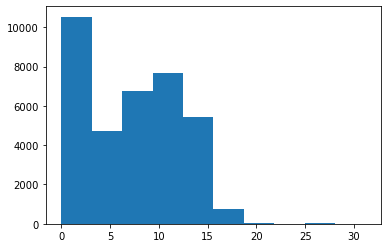

In [23]:
import matplotlib.pyplot as plt
(n,bins,patches)=plt.hist(DF_ini_LDA['Vitesse véhicule 1'])
bins

In [24]:
## ON regarde les distributions des indicateurs pour construire ensuite les classes. 
DF_ini_LDA.describe()

,Distance,Sinus,Cosinus,Vitesse véhicule 1,Vitesse véhicule 2
count,35903.000000,3.590300e+04,35903.000000,3.590300e+04,35903.000000
mean,30.156958,3.468173e-01,0.058937,7.186580e+00,7.498657
std,28.686955,3.849724e-01,0.853267,5.317098e+00,5.003544
min,0.023122,1.487176e-08,-1.000000,2.054132e-07,0.002823
25%,8.720947,2.271819e-02,-0.986449,8.225296e-01,3.231804
50%,21.445750,1.262928e-01,0.121860,7.806542e+00,8.044032
75%,43.219148,7.608266e-01,0.994535,1.192145e+01,11.047660
max,253.342706,1.000000e+00,1.000000,3.119131e+01,25.314611


## On sépare chaque variable dans des intervalles 

In [25]:
# Distance
bins = pd.IntervalIndex.from_tuples([(0, 10), (10, 20),(20,30),(30, 40),(40,50),(50,10000)])
DF_ini_LDA['Intervalle distance']=pd.cut(DF_ini_LDA['Distance'],bins)

In [26]:
DF_ini_LDA['Intervalle distance'].value_counts()

(0, 10]        9473
(50, 10000]    7669
(10, 20]       6921
(20, 30]       6168
(30, 40]       3611
(40, 50]       2061
Name: Intervalle distance, dtype: int64

In [27]:
# Sinus 
bins = pd.IntervalIndex.from_tuples([(0, 0.25), (0.25, 0.5),(0.5,0.75),(0.75, 1)])
DF_ini_LDA['Intervalle sinus']=pd.cut(DF_ini_LDA['Sinus'],bins)

In [28]:
DF_ini_LDA['Intervalle sinus'].value_counts()

(0.0, 0.25]    21034
(0.75, 1.0]     9115
(0.25, 0.5]     3333
(0.5, 0.75]     2421
Name: Intervalle sinus, dtype: int64

In [29]:
# Cosinus 
bins = pd.IntervalIndex.from_tuples([(-1,-0.5),(-0.5, 0),(0, 0.5), (0.5, 1)])
DF_ini_LDA['Intervalle cosinus']=pd.cut(DF_ini_LDA['Cosinus'],bins)

In [30]:
DF_ini_LDA['Intervalle cosinus'].value_counts()

(0.5, 1.0]      15314
(-1.0, -0.5]    13378
(0.0, 0.5]       4215
(-0.5, 0.0]      2996
Name: Intervalle cosinus, dtype: int64

In [31]:
# Vitesse véh 1 
bins = pd.IntervalIndex.from_tuples([(0, 5), (5, 10),(10,15),(15, 35)])#,(20,25),(25,30),(30,35)])
DF_ini_LDA['Intervalle vitesse véhicule 1']=pd.cut(DF_ini_LDA['Vitesse véhicule 1'],bins)

In [32]:
DF_ini_LDA['Intervalle vitesse véhicule 1'].value_counts()

(0, 5]      12957
(10, 15]    11619
(5, 10]      9861
(15, 35]     1466
Name: Intervalle vitesse véhicule 1, dtype: int64

In [33]:
# Vitesse véh 2
bins = pd.IntervalIndex.from_tuples([(0, 5), (5, 10),(10,15),(15, 30)])#,(20,25),(25,30),(30,35)])
DF_ini_LDA['Intervalle vitesse véhicule 2']=pd.cut(DF_ini_LDA['Vitesse véhicule 2'],bins)

In [34]:
DF_ini_LDA['Intervalle vitesse véhicule 2'].value_counts()

(5, 10]     12564
(0, 5]      11470
(10, 15]     9521
(15, 30]     2348
Name: Intervalle vitesse véhicule 2, dtype: int64

In [35]:
DF_ini_LDA

,Couple de trajectoire,Distance,Sinus,Cosinus,Vitesse véhicule 1,Vitesse véhicule 2,Intervalle distance,Intervalle sinus,Intervalle cosinus,Intervalle vitesse véhicule 1,Intervalle vitesse véhicule 2
0,vehicle.bus.rigid 1/ego dans scene-0061,53.479254,0.020871,-0.999782,9.135392,9.736836,"(50, 10000]","(0.0, 0.25]","(-1.0, -0.5]","(5, 10]","(5, 10]"
1,vehicle.bus.rigid 1/ego dans scene-0061,53.928887,0.015877,-0.999874,9.113071,9.736836,"(50, 10000]","(0.0, 0.25]","(-1.0, -0.5]","(5, 10]","(5, 10]"
2,vehicle.bus.rigid 1/ego dans scene-0061,54.377268,0.021460,-0.999770,9.104178,9.736836,"(50, 10000]","(0.0, 0.25]","(-1.0, -0.5]","(5, 10]","(5, 10]"
3,vehicle.bus.rigid 1/ego dans scene-0061,54.830140,0.023996,-0.999712,9.067166,9.736836,"(50, 10000]","(0.0, 0.25]","(-1.0, -0.5]","(5, 10]","(5, 10]"
4,vehicle.bus.rigid 1/ego dans scene-0061,55.285332,0.030690,-0.999529,9.101840,9.736836,"(50, 10000]","(0.0, 0.25]","(-1.0, -0.5]","(5, 10]","(5, 10]"
...,...,...,...,...,...,...,...,...,...,...,...
38021,vehicle.motorcycle 1 /vehicle.motorcycle 2 sce...,70.524364,0.999047,0.043643,6.531769,11.687041,"(50, 10000]","(0.75, 1.0]","(0.0, 0.5]","(5, 10]","(10, 15]"
38022,vehicle.motorcycle 1 /vehicle.motorcycle 2 sce...,73.354761,0.999894,0.014555,6.531769,11.685370,"(50, 10000]","(0.75, 1.0]","(0.0, 0.5]","(5, 10]","(10, 15]"
38023,vehicle.motorcycle 1 /vehicle.motorcycle 2 sce...,76.099012,0.999894,0.014555,6.532070,11.685370,"(50, 10000]","(0.75, 1.0]","(0.0, 0.5]","(5, 10]","(10, 15]"
38024,vehicle.motorcycle 1 /vehicle.motorcycle 2 sce...,78.882958,0.999995,0.003060,6.530783,11.685370,"(50, 10000]","(0.75, 1.0]","(0.0, 0.5]","(5, 10]","(10, 15]"


In [36]:
DF_ini_LDA = DF_ini_LDA.dropna() # On supprime les lignes où on manque d'information 

## Création de la df utile finale 

In [37]:
#df2 = DF_ini_LDA[DF_ini_LDA['Couple de trajectoire']=='vehicle.car 12 /vehicle.motorcycle 1 scene-1100']
#df2[list(df.columns[6:])].value_counts()
#DF_ini_LDA[['Couple de trajectoire']+list(DF_ini_LDA.columns[6:])].value_counts()
# -> Pour récupérer la liste des éléments du value_counts() : .index.tolist()

In [38]:
def LDA_finale(df_ini):
    
    df_finale = pd.DataFrame()
    couples = list(df_ini['Couple de trajectoire'].unique())
    
    # Liste des colonnes des indicateurs
    columns = ['Intervalle distance','Intervalle sinus','Intervalle cosinus','Intervalle vitesse véhicule 1','Intervalle vitesse véhicule 2']
    
    for j in range(0,len(couples)):
        
        nom_couple = couples[j]
        df = df_ini[df_ini['Couple de trajectoire'] == nom_couple] # On prend uniquement les valeurs de ce couple

        df_bis = pd.DataFrame()
        df_bis = df[list(df.columns[6:])].value_counts().to_frame() # On met toutes les valeurs possible dans une df
        df_bis = df_bis.reset_index() # on supprime ces valeurs de l'index
        # On concatène les possibilités dans une même colonne
        df_bis['tout']= [str(df_bis['Intervalle distance'].iloc[k:k+1][k]) + '; '+str(df_bis['Intervalle sinus'].iloc[k:k+1][k]) + '; '+str(df_bis['Intervalle cosinus'].iloc[k:k+1][k])+ '; '+str(df_bis['Intervalle vitesse véhicule 1'].iloc[k:k+1][k]) + '; '+str(df_bis['Intervalle vitesse véhicule 2'].iloc[k:k+1][k]) for k in range(len(df_bis))]
        df_bis = df_bis.set_index('tout') # On met cette colonne en index
        
        df_bis = df_bis.drop(columns,axis=1) #On supprime les colonnes des indicateurs seuls, on garde seulement la concaténation
       
        df_bis.columns = [nom_couple] #On renomme la colonne du nombre d'apparition de chaque classe avec le nom de l'indiv
        df_bis[nom_couple] = df_bis[nom_couple]/df_bis[nom_couple].sum() #On met ces valeurs en fréquences
        
        df_bis = df_bis.transpose() # On transpose pour avoir les individus en ligne 
        
        df_finale = pd.concat([df_finale,df_bis]) # on concatène avec les valeurs d'avant
    
    df_finale = df_finale.fillna(0) # On met des 0 à la place des Nan 
    
    return df_finale

In [39]:
DF_finale_LDA = LDA_finale(DF_ini_LDA)
DF_finale_LDA

tout,"(50, 10000]; (0.0, 0.25]; (-1.0, -0.5]; (5, 10]; (5, 10]","(20, 30]; (0.0, 0.25]; (-1.0, -0.5]; (5, 10]; (5, 10]","(0, 10]; (0.0, 0.25]; (0.5, 1.0]; (5, 10]; (0, 5]","(10, 20]; (0.0, 0.25]; (0.5, 1.0]; (5, 10]; (0, 5]","(20, 30]; (0.0, 0.25]; (0.5, 1.0]; (5, 10]; (0, 5]","(0, 10]; (0.0, 0.25]; (0.5, 1.0]; (5, 10]; (5, 10]","(10, 20]; (0.5, 0.75]; (0.5, 1.0]; (0, 5]; (5, 10]","(0, 10]; (0.25, 0.5]; (0.5, 1.0]; (5, 10]; (5, 10]","(10, 20]; (0.75, 1.0]; (0.0, 0.5]; (0, 5]; (5, 10]","(10, 20]; (0.75, 1.0]; (0.5, 1.0]; (0, 5]; (5, 10]",...,"(0, 10]; (0.75, 1.0]; (0.5, 1.0]; (10, 15]; (5, 10]","(0, 10]; (0.75, 1.0]; (0.0, 0.5]; (10, 15]; (0, 5]","(10, 20]; (0.75, 1.0]; (-0.5, 0.0]; (10, 15]; (0, 5]","(10, 20]; (0.75, 1.0]; (-0.5, 0.0]; (15, 35]; (0, 5]","(10, 20]; (0.5, 0.75]; (-1.0, -0.5]; (10, 15]; (0, 5]","(20, 30]; (0.75, 1.0]; (-1.0, -0.5]; (10, 15]; (0, 5]","(40, 50]; (0.75, 1.0]; (-0.5, 0.0]; (10, 15]; (0, 5]","(50, 10000]; (0.75, 1.0]; (0.0, 0.5]; (10, 15]; (10, 15]","(0, 10]; (0.75, 1.0]; (0.5, 1.0]; (5, 10]; (10, 15]","(40, 50]; (0.75, 1.0]; (-0.5, 0.0]; (0, 5]; (10, 15]"
vehicle.bus.rigid 1/ego dans scene-0061,1.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
vehicle.car 1/ego dans scene-0061,0.0,1.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
vehicle.car 2/ego dans scene-0061,0.0,0.0,0.197479,0.12605,0.105042,0.084034,0.084034,0.079832,0.071429,0.071429,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
vehicle.car 3/ego dans scene-0061,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
vehicle.car 4/ego dans scene-0061,0.0,0.0,0.125984,0.00000,0.000000,0.089239,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
vehicle.car 11 /vehicle.motorcycle 1 scene-1100,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
vehicle.car 11 /vehicle.motorcycle 2 scene-1100,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
vehicle.car 12 /vehicle.motorcycle 1 scene-1100,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000
vehicle.car 12 /vehicle.motorcycle 2 scene-1100,0.0,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000


In [40]:
DF_finale_LDA.to_csv('/Users/tiffanydarini/Desktop/test.csv')

## Application du package LDA

In [41]:
from sklearn.decomposition import NMF, LatentDirichletAllocation

Text(0, 0.5, 'Perplexity')

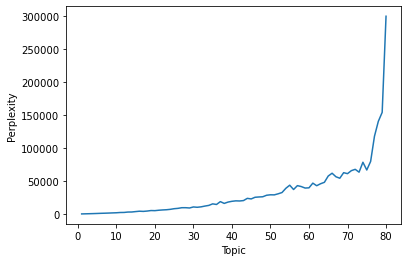

In [42]:
## ON va tracer la perplexité en fonction du nombre de topic 
L_topic = []
L_perplexity = []
for k in range(1,81):
    L_topic.append(k)
    lda = LatentDirichletAllocation(n_components=k,random_state=0)
    lda_output = lda.fit_transform(DF_finale_LDA)
    L_perplexity.append(lda.perplexity(DF_finale_LDA))

plt.plot(L_topic,L_perplexity)
plt.xlabel('Topic')
plt.ylabel('Perplexity')
## On voit que la valeur optimale est vers 75 topics 

In [43]:
lda = LatentDirichletAllocation(n_components=75,random_state=0)
lda_output = lda.fit_transform(DF_finale_LDA)
print(len(lda_output)) # Chaque ligne de lda correspond à un individu 
print(len(lda_output[0])) # Dans une ligne, on a le pourcentage de ressemblance d'un individu à un topic 

1314
75


In [44]:
## On représente le résultat pour chaque individu dans une ddataframe 
topicnames = ["Topic " + str(i) for i in range(len(lda_output[0]))]
df_topic = pd.DataFrame()
df_topic['Topic']= topicnames
df_topic = df_topic.set_index('Topic')
L_dominant_topic = [] # Liste pour avoir le topic qui prédomine pour chaque individu
for k in range(len(lda_output)):
    df_topic[list(DF_finale_LDA.index)[k]]=lda_output[k]
    L_dominant_topic.append(df_topic[list(DF_finale_LDA.index)[k]].argmax())
df_topic = df_topic.transpose()
df_topic['Topic dominant']=L_dominant_topic
df_topic

Topic,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,...,Topic 66,Topic 67,Topic 68,Topic 69,Topic 70,Topic 71,Topic 72,Topic 73,Topic 74,Topic dominant
vehicle.bus.rigid 1/ego dans scene-0061,0.506667,0.006667,0.006667,0.006667,0.006667,0.006667,0.006667,0.006667,0.006667,0.006667,...,0.006667,0.006667,0.006667,0.006667,0.006667,0.006667,0.006667,0.006667,0.006667,0
vehicle.car 1/ego dans scene-0061,0.006667,0.006667,0.006667,0.006667,0.006667,0.006667,0.006667,0.006667,0.006667,0.006667,...,0.006667,0.006667,0.006667,0.006667,0.006667,0.006667,0.006667,0.006667,0.506667,74
vehicle.car 2/ego dans scene-0061,0.006681,0.006681,0.006681,0.040365,0.006681,0.006681,0.006681,0.006681,0.006681,0.006681,...,0.006681,0.006681,0.006681,0.006681,0.006681,0.006681,0.006681,0.006681,0.189839,74
vehicle.car 3/ego dans scene-0061,0.006667,0.006667,0.006667,0.006667,0.006667,0.006667,0.006667,0.006667,0.006667,0.006667,...,0.006667,0.006667,0.006667,0.006667,0.006667,0.006667,0.006667,0.006667,0.006667,14
vehicle.car 4/ego dans scene-0061,0.006667,0.006667,0.006667,0.006667,0.006667,0.006667,0.006667,0.006667,0.006667,0.006667,...,0.006667,0.006667,0.006667,0.006667,0.006667,0.006667,0.006667,0.006667,0.006667,59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
vehicle.car 11 /vehicle.motorcycle 1 scene-1100,0.006667,0.006667,0.006667,0.006667,0.006667,0.006667,0.006667,0.006667,0.006667,0.006667,...,0.006667,0.006667,0.006667,0.006667,0.006667,0.006667,0.006667,0.006667,0.006667,35
vehicle.car 11 /vehicle.motorcycle 2 scene-1100,0.006667,0.006667,0.006667,0.006667,0.006667,0.006667,0.006667,0.006667,0.006667,0.006667,...,0.006667,0.006667,0.273333,0.006667,0.006667,0.006667,0.006667,0.006667,0.006667,68
vehicle.car 12 /vehicle.motorcycle 1 scene-1100,0.006712,0.006712,0.006712,0.006712,0.006712,0.006712,0.006712,0.006712,0.006712,0.006712,...,0.006712,0.038843,0.006712,0.006712,0.006712,0.006712,0.006712,0.006712,0.006712,63
vehicle.car 12 /vehicle.motorcycle 2 scene-1100,0.006667,0.006667,0.006667,0.006667,0.006667,0.006667,0.006667,0.006667,0.006667,0.006667,...,0.006667,0.006667,0.006667,0.006667,0.006667,0.006667,0.006667,0.006667,0.006667,57


In [45]:
## On regarde le nombre d'éléments dans chaque topic
df_topic_distribution = df_topic['Topic dominant'].value_counts().reset_index(name="Nombre de couples dans le topic")
df_topic_distribution.columns = ['Numéro du Topic', 'Nombre de couples dans le topic']
df_topic_distribution['Nombre de couples dans le topic'].describe()

count    75.000000
mean     17.520000
std      16.847776
min       1.000000
25%       7.000000
50%      12.000000
75%      21.500000
max      70.000000
Name: Nombre de couples dans le topic, dtype: float64

In [46]:
## On regarde maintenant à quoi correspondent les topics par rapports à nos catégories d'indicateurs 
print(len(lda.components_)) # chaque ligne correspond à un topic 
print(len(lda.components_[0])) # Dans une ligne, on a le pourcentage d'appartenance à une classe 

75
640


In [47]:
## On représente le résultat pour chaque individu dans une ddataframe 
df_topic_description = pd.DataFrame()
df_topic_description['Caractéristiques (Dist/sin/cos/vit_veh1/vit_veh2)']= list(DF_finale_LDA.columns)
df_topic_description = df_topic_description.set_index('Caractéristiques (Dist/sin/cos/vit_veh1/vit_veh2)')

L_dominant_catego = [] # Liste pour avoir la catego qui prédomine pour chaque topic
for k in range(len(lda.components_)):
    df_topic_description['Topic '+str(k)]=(lda.components_/lda.components_.sum(axis=1)[:, np.newaxis])[k]
    indice_ligne_max = df_topic_description['Topic '+str(k)].argmax()
    L_dominant_catego.append(list(DF_finale_LDA.columns)[indice_ligne_max])
df_topic_description = df_topic_description.transpose()
#df_topic_description['Catégorie dominante']=L_dominant_catego
df_topic_description
## On a le poids de chaque catégorie dans chaque topic 

Caractéristiques (Dist/sin/cos/vit_veh1/vit_veh2),"(50, 10000]; (0.0, 0.25]; (-1.0, -0.5]; (5, 10]; (5, 10]","(20, 30]; (0.0, 0.25]; (-1.0, -0.5]; (5, 10]; (5, 10]","(0, 10]; (0.0, 0.25]; (0.5, 1.0]; (5, 10]; (0, 5]","(10, 20]; (0.0, 0.25]; (0.5, 1.0]; (5, 10]; (0, 5]","(20, 30]; (0.0, 0.25]; (0.5, 1.0]; (5, 10]; (0, 5]","(0, 10]; (0.0, 0.25]; (0.5, 1.0]; (5, 10]; (5, 10]","(10, 20]; (0.5, 0.75]; (0.5, 1.0]; (0, 5]; (5, 10]","(0, 10]; (0.25, 0.5]; (0.5, 1.0]; (5, 10]; (5, 10]","(10, 20]; (0.75, 1.0]; (0.0, 0.5]; (0, 5]; (5, 10]","(10, 20]; (0.75, 1.0]; (0.5, 1.0]; (0, 5]; (5, 10]",...,"(0, 10]; (0.75, 1.0]; (0.5, 1.0]; (10, 15]; (5, 10]","(0, 10]; (0.75, 1.0]; (0.0, 0.5]; (10, 15]; (0, 5]","(10, 20]; (0.75, 1.0]; (-0.5, 0.0]; (10, 15]; (0, 5]","(10, 20]; (0.75, 1.0]; (-0.5, 0.0]; (15, 35]; (0, 5]","(10, 20]; (0.5, 0.75]; (-1.0, -0.5]; (10, 15]; (0, 5]","(20, 30]; (0.75, 1.0]; (-1.0, -0.5]; (10, 15]; (0, 5]","(40, 50]; (0.75, 1.0]; (-0.5, 0.0]; (10, 15]; (0, 5]","(50, 10000]; (0.75, 1.0]; (0.0, 0.5]; (10, 15]; (10, 15]","(0, 10]; (0.75, 1.0]; (0.5, 1.0]; (5, 10]; (10, 15]","(40, 50]; (0.75, 1.0]; (-0.5, 0.0]; (0, 5]; (10, 15]"
Topic 0,0.247606,0.000308,0.000308,0.000308,0.000308,0.000308,0.000308,0.000308,0.000308,0.000308,...,0.000308,0.000308,0.000308,0.000308,0.000308,0.000308,0.000308,0.000308,0.000308,0.000308
Topic 1,0.000950,0.000950,0.000950,0.000950,0.000950,0.000950,0.000950,0.000950,0.000950,0.000950,...,0.000950,0.000950,0.000950,0.000950,0.000950,0.000950,0.000950,0.000950,0.000950,0.000950
Topic 2,0.000750,0.000750,0.000750,0.000750,0.000750,0.000750,0.000750,0.000750,0.000750,0.000750,...,0.000750,0.000750,0.000750,0.000750,0.000750,0.000750,0.000750,0.000750,0.000750,0.000750
Topic 3,0.000569,0.000569,0.000569,0.000569,0.000569,0.000569,0.000569,0.000569,0.000569,0.000569,...,0.000569,0.000569,0.000569,0.000569,0.000569,0.000569,0.000569,0.000569,0.000569,0.000569
Topic 4,0.001259,0.001259,0.001259,0.001259,0.001259,0.001259,0.001259,0.001259,0.001259,0.001259,...,0.001259,0.001259,0.001259,0.001259,0.001259,0.001259,0.001259,0.001259,0.001259,0.001259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Topic 70,0.001009,0.001009,0.001009,0.001009,0.001009,0.001009,0.001009,0.001009,0.001009,0.001009,...,0.001009,0.001009,0.001009,0.001009,0.001009,0.001009,0.001009,0.001009,0.001009,0.001009
Topic 71,0.000540,0.000540,0.000540,0.000540,0.000540,0.000540,0.000540,0.000540,0.003479,0.002381,...,0.000540,0.000540,0.000540,0.000540,0.000540,0.000540,0.000540,0.000540,0.000540,0.000540
Topic 72,0.000819,0.000819,0.000819,0.000819,0.000819,0.000819,0.000819,0.000819,0.000819,0.000819,...,0.000819,0.000819,0.000819,0.000819,0.000819,0.000819,0.000819,0.000819,0.000819,0.000819
Topic 73,0.000792,0.000792,0.000792,0.000792,0.000792,0.000792,0.000792,0.000792,0.000792,0.000792,...,0.000792,0.000792,0.000792,0.000792,0.000792,0.000792,0.000792,0.000792,0.000792,0.000792


<AxesSubplot:xlabel='Caractéristiques (Dist/sin/cos/vit_veh1/vit_veh2)'>

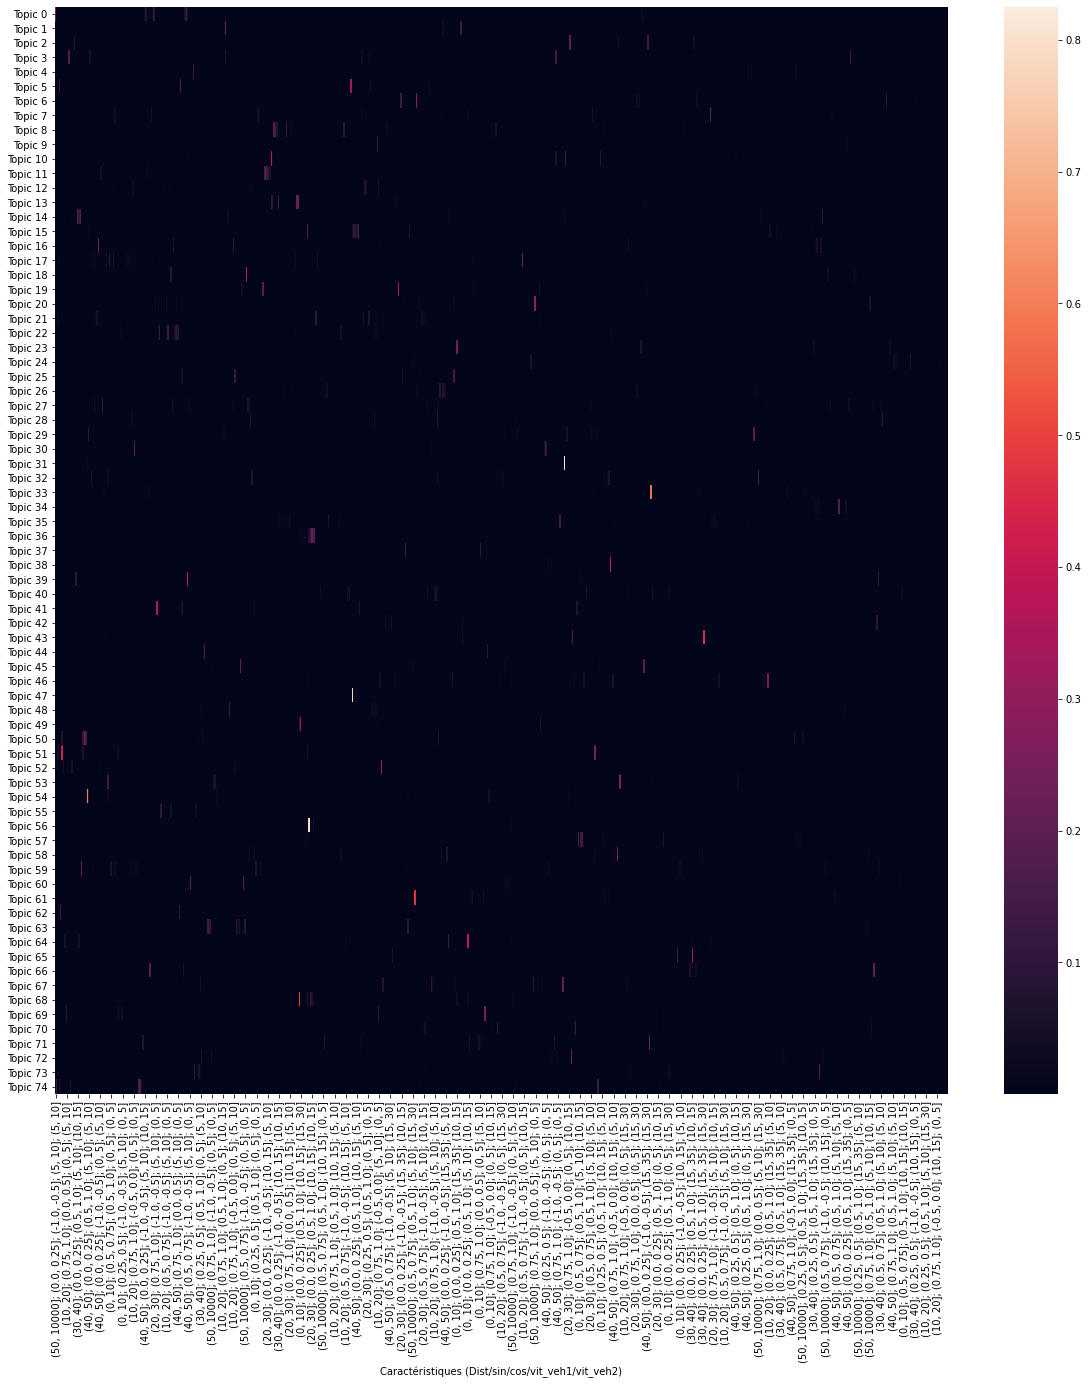

In [48]:
import seaborn as sns
f = plt.subplots(figsize=(20,20))
sns.heatmap(df_topic_description)

In [49]:
df_topic_description['Catégorie dominante']=L_dominant_catego
df_topic_description['Catégorie dominante'].value_counts()
## Les résultats montrent que chaque topic est associé en majorité à une catégorie différente 

(50, 10000]; (0.5, 0.75]; (0.5, 1.0]; (5, 10]; (10, 15]       1
(50, 10000]; (0.5, 0.75]; (-1.0, -0.5]; (0, 5]; (5, 10]       1
(0, 10]; (0.0, 0.25]; (0.5, 1.0]; (5, 10]; (5, 10]            1
(40, 50]; (0.0, 0.25]; (-1.0, -0.5]; (5, 10]; (0, 5]          1
(0, 10]; (0.0, 0.25]; (0.5, 1.0]; (10, 15]; (5, 10]           1
                                                             ..
(50, 10000]; (0.25, 0.5]; (-1.0, -0.5]; (0, 5]; (15, 30]      1
(10, 20]; (0.75, 1.0]; (0.0, 0.5]; (5, 10]; (10, 15]          1
(50, 10000]; (0.0, 0.25]; (0.5, 1.0]; (15, 35]; (10, 15]      1
(50, 10000]; (0.0, 0.25]; (-1.0, -0.5]; (5, 10]; (10, 15]     1
(50, 10000]; (0.0, 0.25]; (-1.0, -0.5]; (15, 35]; (10, 15]    1
Name: Catégorie dominante, Length: 75, dtype: int64

In [50]:
df_topic_description

Caractéristiques (Dist/sin/cos/vit_veh1/vit_veh2),"(50, 10000]; (0.0, 0.25]; (-1.0, -0.5]; (5, 10]; (5, 10]","(20, 30]; (0.0, 0.25]; (-1.0, -0.5]; (5, 10]; (5, 10]","(0, 10]; (0.0, 0.25]; (0.5, 1.0]; (5, 10]; (0, 5]","(10, 20]; (0.0, 0.25]; (0.5, 1.0]; (5, 10]; (0, 5]","(20, 30]; (0.0, 0.25]; (0.5, 1.0]; (5, 10]; (0, 5]","(0, 10]; (0.0, 0.25]; (0.5, 1.0]; (5, 10]; (5, 10]","(10, 20]; (0.5, 0.75]; (0.5, 1.0]; (0, 5]; (5, 10]","(0, 10]; (0.25, 0.5]; (0.5, 1.0]; (5, 10]; (5, 10]","(10, 20]; (0.75, 1.0]; (0.0, 0.5]; (0, 5]; (5, 10]","(10, 20]; (0.75, 1.0]; (0.5, 1.0]; (0, 5]; (5, 10]",...,"(0, 10]; (0.75, 1.0]; (0.0, 0.5]; (10, 15]; (0, 5]","(10, 20]; (0.75, 1.0]; (-0.5, 0.0]; (10, 15]; (0, 5]","(10, 20]; (0.75, 1.0]; (-0.5, 0.0]; (15, 35]; (0, 5]","(10, 20]; (0.5, 0.75]; (-1.0, -0.5]; (10, 15]; (0, 5]","(20, 30]; (0.75, 1.0]; (-1.0, -0.5]; (10, 15]; (0, 5]","(40, 50]; (0.75, 1.0]; (-0.5, 0.0]; (10, 15]; (0, 5]","(50, 10000]; (0.75, 1.0]; (0.0, 0.5]; (10, 15]; (10, 15]","(0, 10]; (0.75, 1.0]; (0.5, 1.0]; (5, 10]; (10, 15]","(40, 50]; (0.75, 1.0]; (-0.5, 0.0]; (0, 5]; (10, 15]",Catégorie dominante
Topic 0,0.247606,0.000308,0.000308,0.000308,0.000308,0.000308,0.000308,0.000308,0.000308,0.000308,...,0.000308,0.000308,0.000308,0.000308,0.000308,0.000308,0.000308,0.000308,0.000308,"(50, 10000]; (0.0, 0.25]; (-1.0, -0.5]; (5, 10..."
Topic 1,0.000950,0.000950,0.000950,0.000950,0.000950,0.000950,0.000950,0.000950,0.000950,0.000950,...,0.000950,0.000950,0.000950,0.000950,0.000950,0.000950,0.000950,0.000950,0.000950,"(20, 30]; (0.75, 1.0]; (-0.5, 0.0]; (0, 5]; (5..."
Topic 2,0.000750,0.000750,0.000750,0.000750,0.000750,0.000750,0.000750,0.000750,0.000750,0.000750,...,0.000750,0.000750,0.000750,0.000750,0.000750,0.000750,0.000750,0.000750,0.000750,"(50, 10000]; (0.25, 0.5]; (0.5, 1.0]; (0, 5]; ..."
Topic 3,0.000569,0.000569,0.000569,0.000569,0.000569,0.000569,0.000569,0.000569,0.000569,0.000569,...,0.000569,0.000569,0.000569,0.000569,0.000569,0.000569,0.000569,0.000569,0.000569,"(20, 30]; (0.75, 1.0]; (0.0, 0.5]; (0, 5]; (5,..."
Topic 4,0.001259,0.001259,0.001259,0.001259,0.001259,0.001259,0.001259,0.001259,0.001259,0.001259,...,0.001259,0.001259,0.001259,0.001259,0.001259,0.001259,0.001259,0.001259,0.001259,"(30, 40]; (0.75, 1.0]; (0.5, 1.0]; (0, 5]; (5,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Topic 70,0.001009,0.001009,0.001009,0.001009,0.001009,0.001009,0.001009,0.001009,0.001009,0.001009,...,0.001009,0.001009,0.001009,0.001009,0.001009,0.001009,0.001009,0.001009,0.001009,"(40, 50]; (0.75, 1.0]; (-0.5, 0.0]; (5, 10]; (..."
Topic 71,0.000540,0.000540,0.000540,0.000540,0.000540,0.000540,0.000540,0.000540,0.003479,0.002381,...,0.000540,0.000540,0.000540,0.000540,0.000540,0.000540,0.000540,0.000540,0.000540,"(50, 10000]; (0.25, 0.5]; (0.5, 1.0]; (10, 15]..."
Topic 72,0.000819,0.000819,0.000819,0.000819,0.000819,0.000819,0.000819,0.000819,0.000819,0.000819,...,0.000819,0.000819,0.000819,0.000819,0.000819,0.000819,0.000819,0.000819,0.000819,"(50, 10000]; (0.25, 0.5]; (-1.0, -0.5]; (0, 5]..."
Topic 73,0.000792,0.000792,0.000792,0.000792,0.000792,0.000792,0.000792,0.000792,0.000792,0.000792,...,0.000792,0.000792,0.000792,0.000792,0.000792,0.000792,0.000792,0.000792,0.000792,"(50, 10000]; (0.0, 0.25]; (0.5, 1.0]; (5, 10];..."


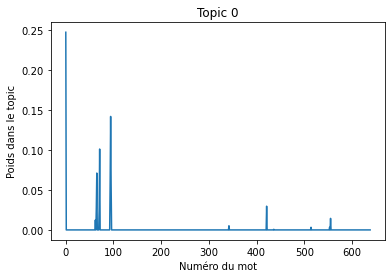

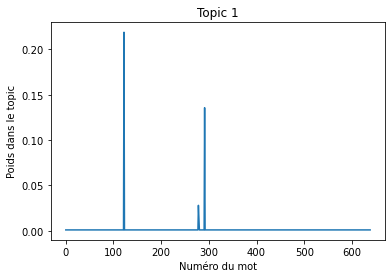

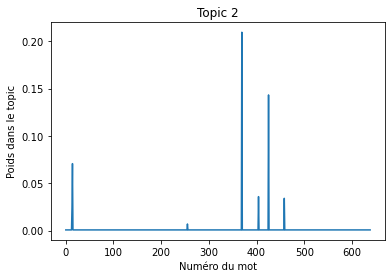

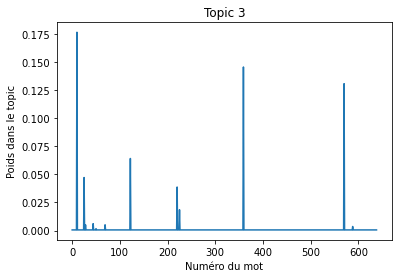

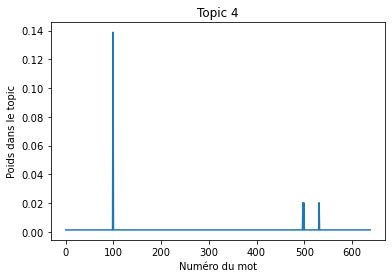

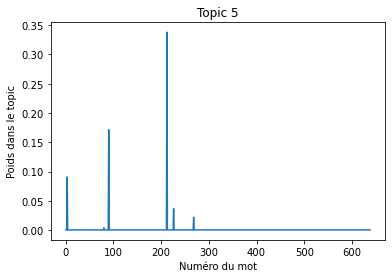

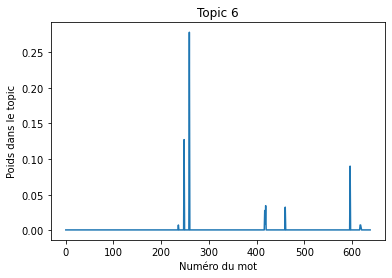

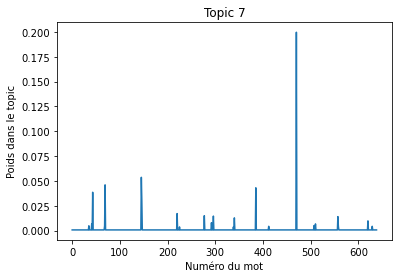

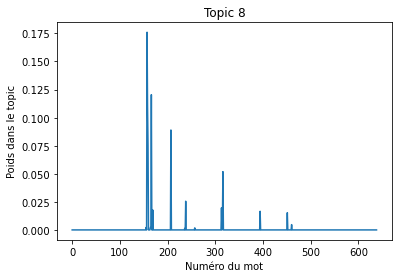

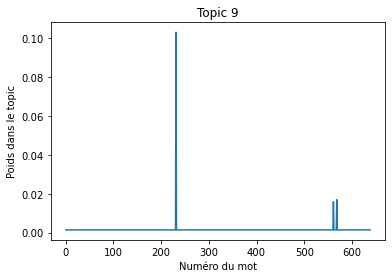

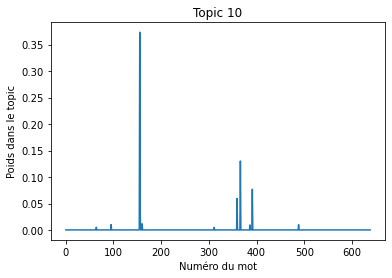

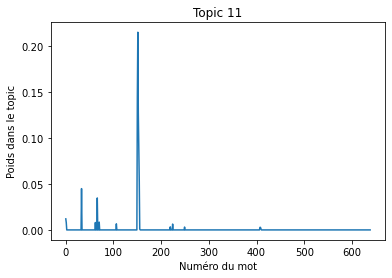

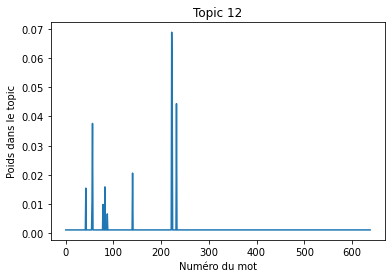

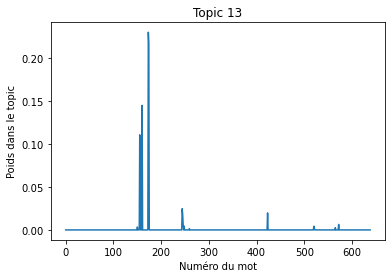

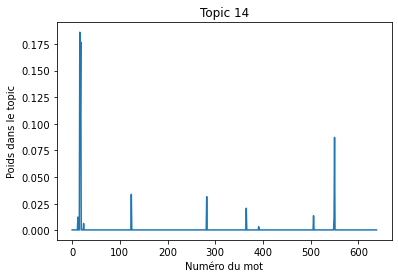

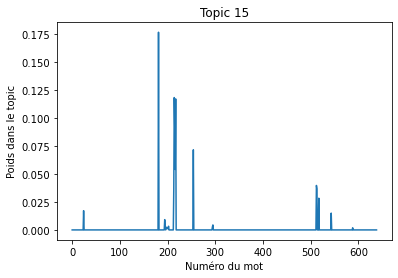

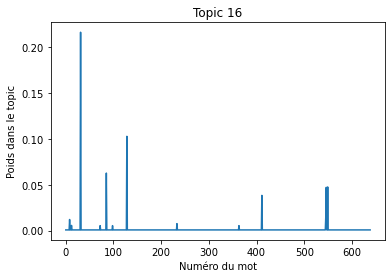

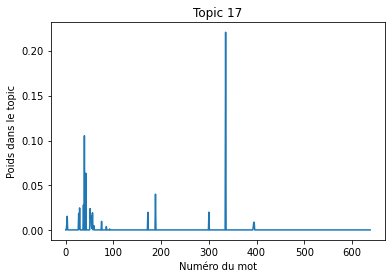

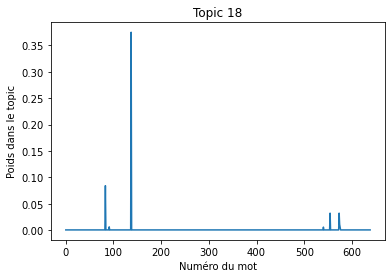

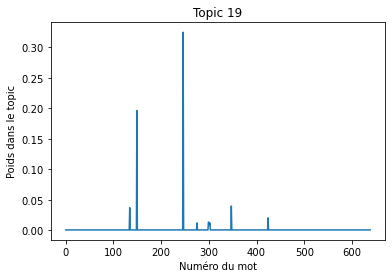

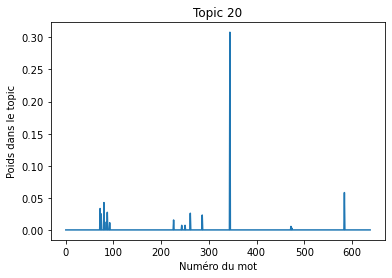

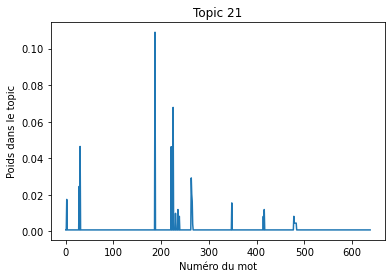

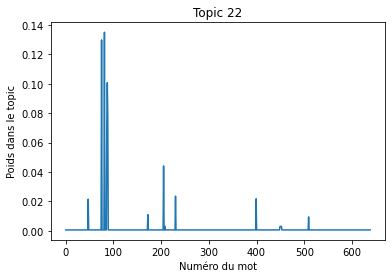

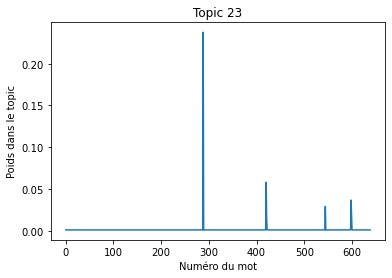

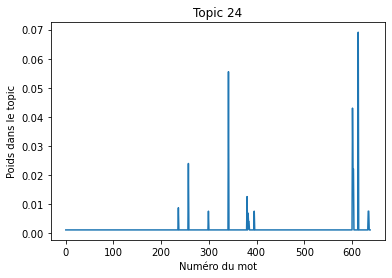

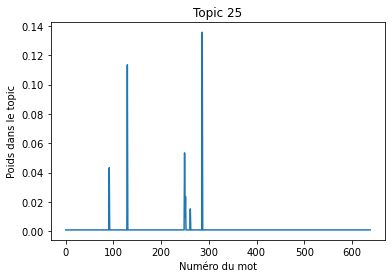

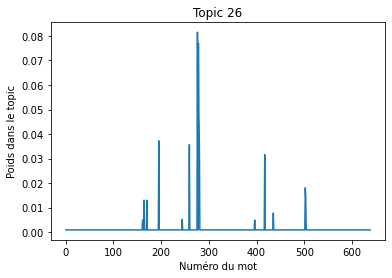

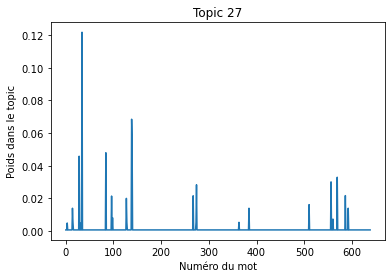

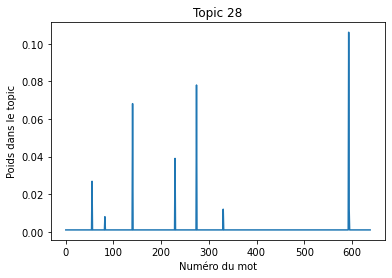

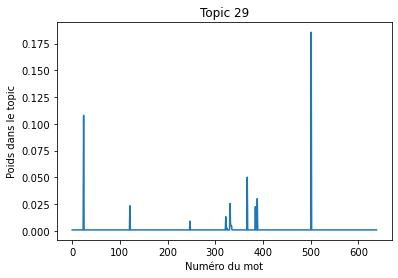

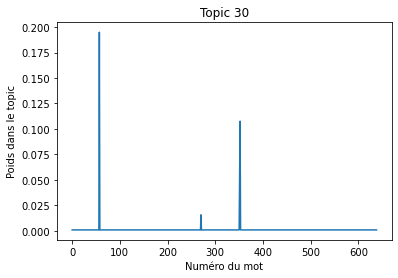

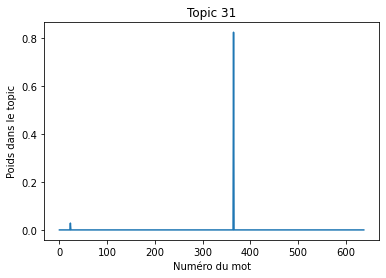

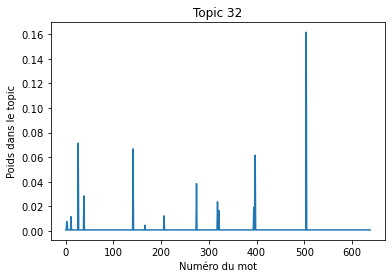

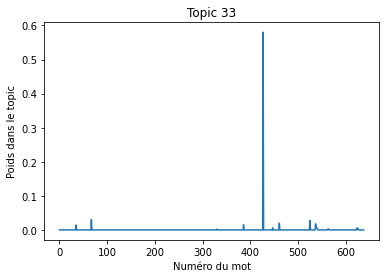

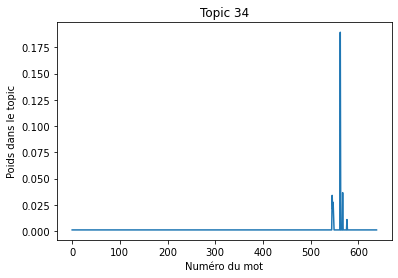

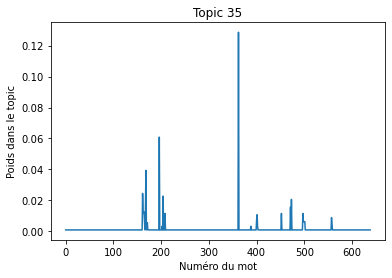

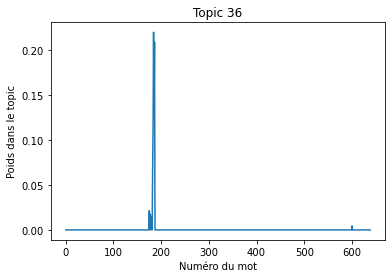

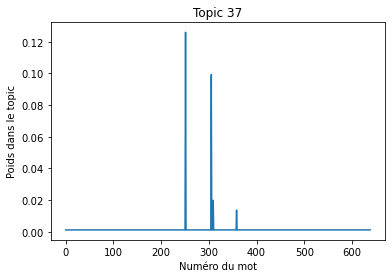

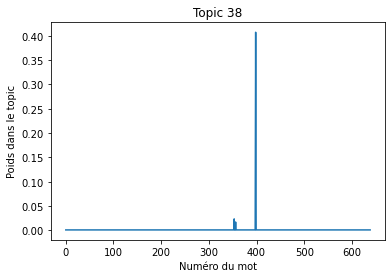

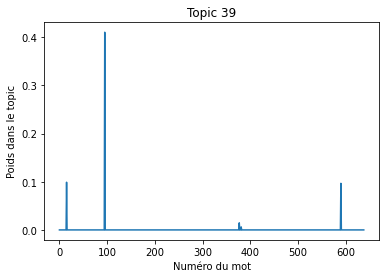

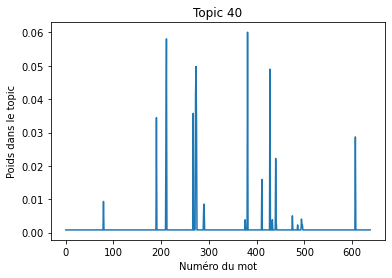

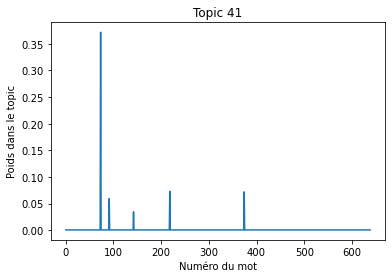

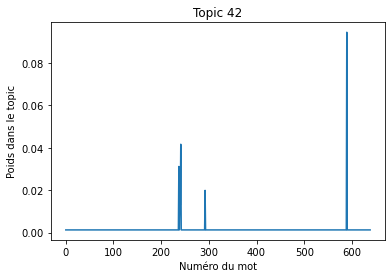

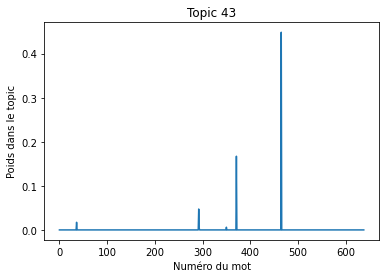

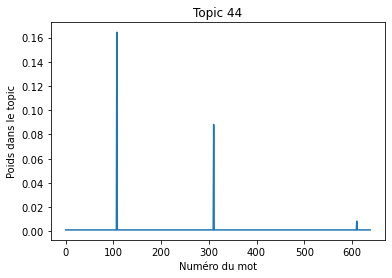

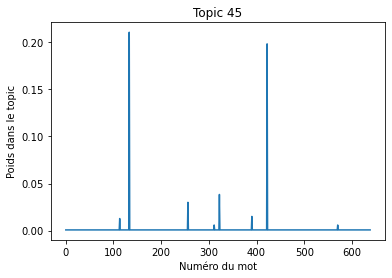

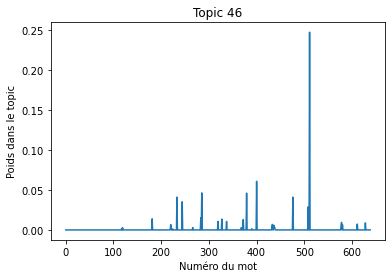

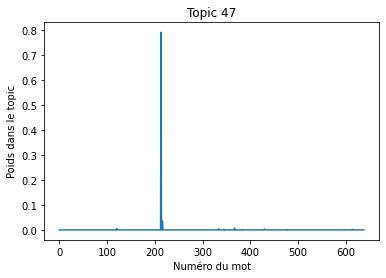

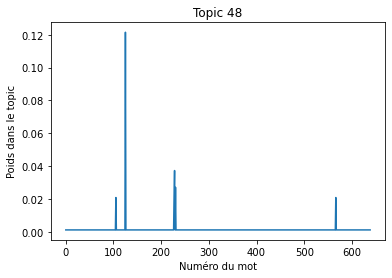

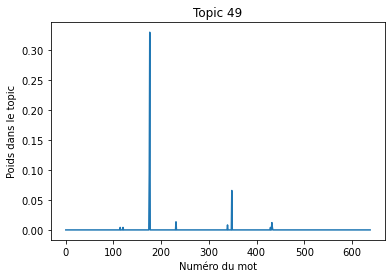

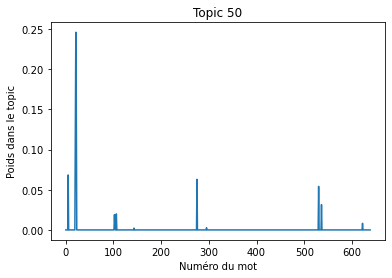

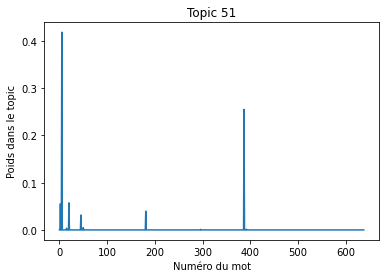

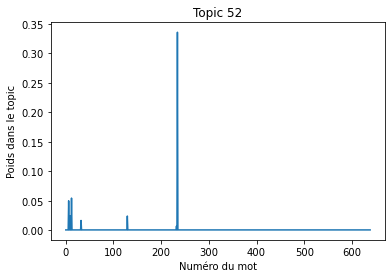

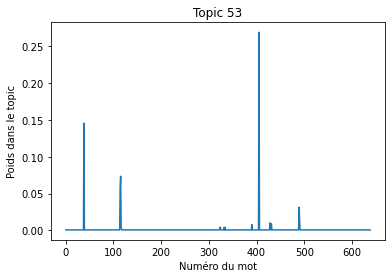

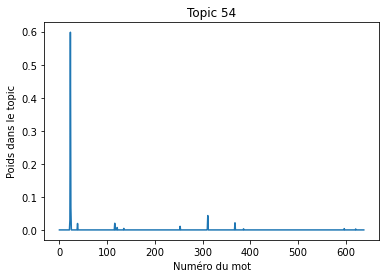

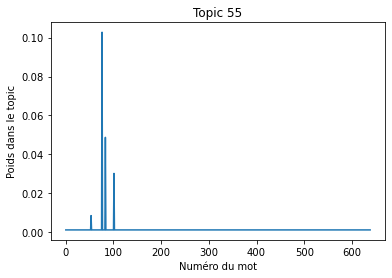

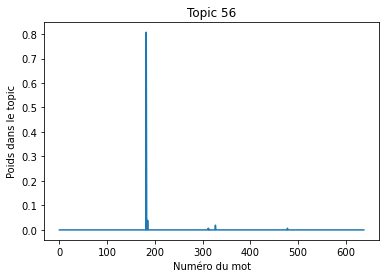

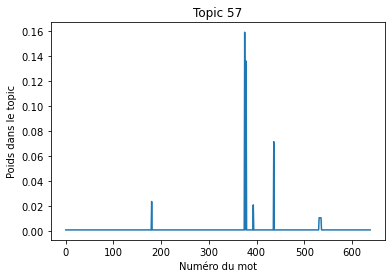

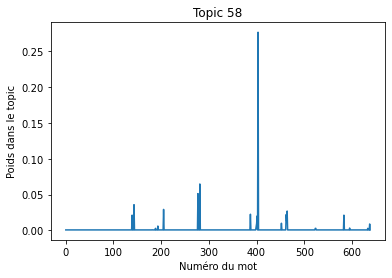

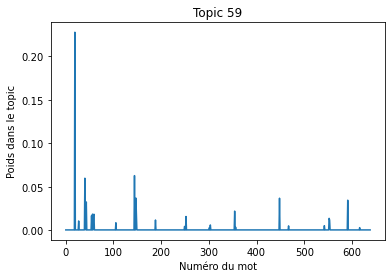

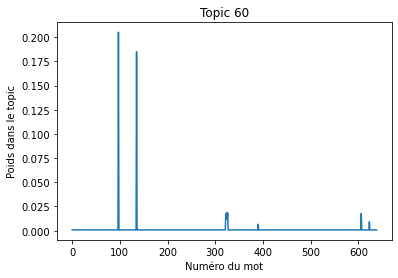

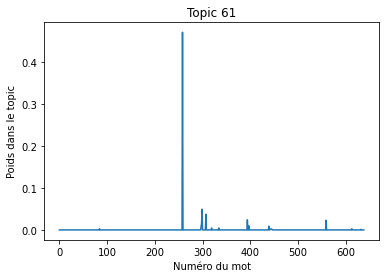

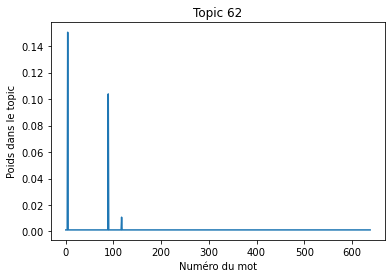

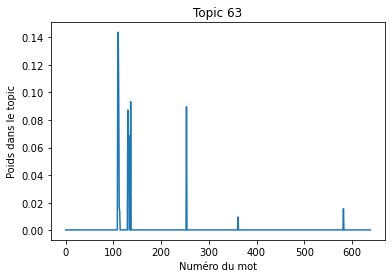

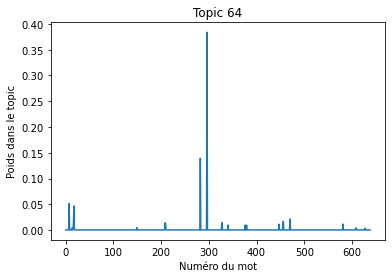

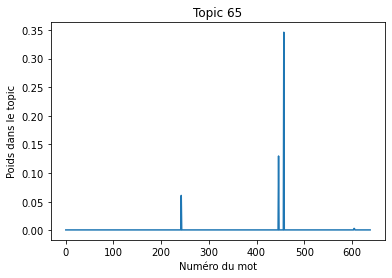

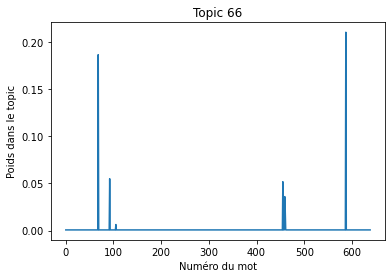

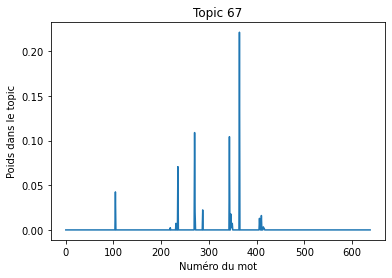

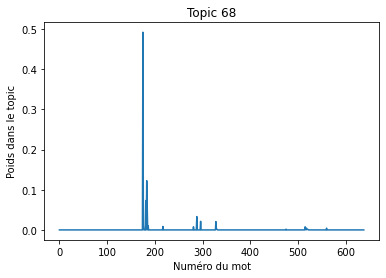

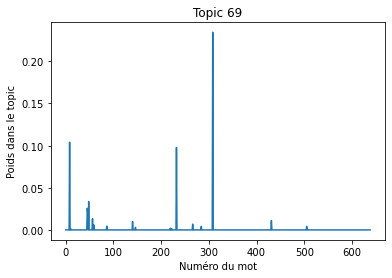

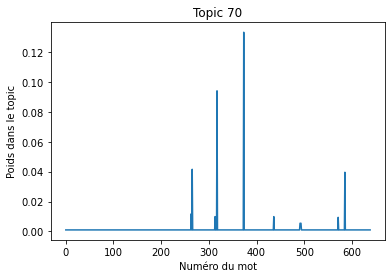

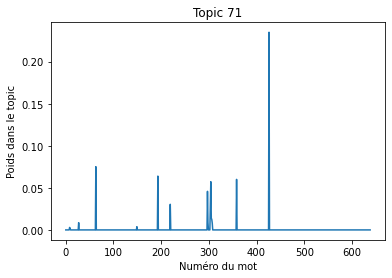

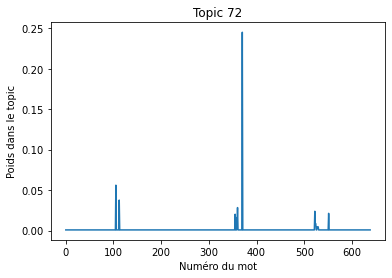

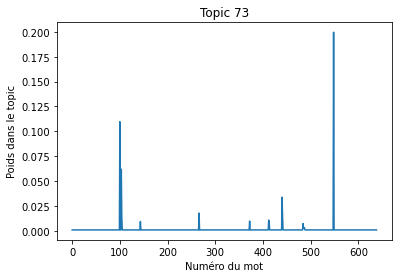

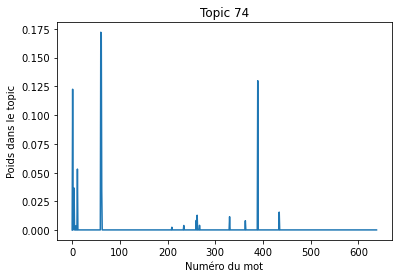

In [51]:
for k in range(len(df_topic_description)):
    plt.plot(df_topic_description.loc['Topic '+str(k),:].values[:-2])
    plt.title('Topic '+str(k))
    plt.ylabel('Poids dans le topic')
    plt.xlabel('Numéro du mot')
    plt.show()

### Analyse des topics 

In [52]:
df_topic_description.loc['Topic '+str(k),:]

Caractéristiques (Dist/sin/cos/vit_veh1/vit_veh2)
(50, 10000]; (0.0, 0.25]; (-1.0, -0.5]; (5, 10]; (5, 10]                                             0.000305
(20, 30]; (0.0, 0.25]; (-1.0, -0.5]; (5, 10]; (5, 10]                                                0.122455
(0, 10]; (0.0, 0.25]; (0.5, 1.0]; (5, 10]; (0, 5]                                                    0.000305
(10, 20]; (0.0, 0.25]; (0.5, 1.0]; (5, 10]; (0, 5]                                                   0.019899
(20, 30]; (0.0, 0.25]; (0.5, 1.0]; (5, 10]; (0, 5]                                                   0.036671
                                                                                  ...                        
(40, 50]; (0.75, 1.0]; (-0.5, 0.0]; (10, 15]; (0, 5]                                                 0.000305
(50, 10000]; (0.75, 1.0]; (0.0, 0.5]; (10, 15]; (10, 15]                                             0.000305
(0, 10]; (0.75, 1.0]; (0.5, 1.0]; (5, 10]; (10, 15]                   

### Analyse des topics / au car following 

In [53]:
### On conserve uniquement quelques couples en car following 
L_Cfollowing = ['vehicle.car 4/ego dans scene-0061','vehicle.car 2 /vehicle.truck 1 scene-0061',\
                'vehicle.car 2 /vehicle.car 4 scene-0103','vehicle.car 2 /vehicle.car 3 scene-0757',\
                'vehicle.car 2 /vehicle.car 4 scene-0757','vehicle.car 2 /vehicle.car 5 scene-0757',\
                'vehicle.car 2 /vehicle.car 11 scene-0757','vehicle.car 3 /vehicle.car 4 scene-0757',\
                'vehicle.car 3 /vehicle.car 5 scene-0757','vehicle.car 3 /vehicle.car 11 scene-0757',\
                'vehicle.car 4 /vehicle.car 5 scene-0757','vehicle.car 4 /vehicle.car 11 scene-0757',\
                'vehicle.car 5 /vehicle.car 11 scene-0757','vehicle.car 1 /vehicle.car 10 scene-0757',\
                'vehicle.car 1 /vehicle.truck 1 scene-0757','vehicle.car 10 /vehicle.truck 1 scene-0757',\
                'vehicle.car 6 /vehicle.car 7 scene-0757','vehicle.car 6 /vehicle.car 8 scene-0757',\
                'vehicle.car 7 /vehicle.car 8 scene-0757','vehicle.car 3/ego dans scene-1094',\
                'vehicle.car 1/ego dans scene-1094','vehicle.car 4/ego dans scene-1094',\
                'vehicle.car 1 /vehicle.car 3 scene-1094','vehicle.car 1 /vehicle.car 4 scene-1094',\
                'vehicle.car 3 /vehicle.car 4 scene-1094','vehicle.car 12/ego dans scene-0796',\
               'vehicle.car 5 /vehicle.car 18 scene-0796','vehicle.car 9 /vehicle.car 19 scene-0796',\
               'vehicle.car 9 /vehicle.car 18 scene-0796','vehicle.car 5 /vehicle.car 9 scene-0796',\
               'vehicle.car 5 /vehicle.car 19 scene-0796','vehicle.car 5 /vehicle.car 6 scene-0796',\
               'vehicle.car 6 /vehicle.car 19 scene-0796','vehicle.car 6 /vehicle.car 9 scene-0796',\
               'vehicle.car 6 /vehicle.car 18 scene-0796']

In [80]:
df_CF

Topic,Topic dominant
vehicle.car 4/ego dans scene-0061,59
vehicle.car 12/ego dans scene-0796,68
vehicle.car 1/ego dans scene-1094,59
vehicle.car 3/ego dans scene-1094,59
vehicle.car 4/ego dans scene-1094,71
vehicle.car 2 /vehicle.truck 1 scene-0061,51
vehicle.car 2 /vehicle.car 4 scene-0103,59
vehicle.car 2 /vehicle.car 3 scene-0757,50
vehicle.car 4 /vehicle.car 11 scene-0757,50
vehicle.car 5 /vehicle.car 11 scene-0757,51


In [70]:
df_CF = df_topic[df_topic.index.isin(L_Cfollowing )][['Topic dominant']]
df_CF.value_counts()

Topic dominant
49                5
59                5
50                4
68                4
51                2
19                1
22                1
43                1
71                1
dtype: int64

In [75]:
df_CF_topic = df_topic_description[['Catégorie dominante']]


In [77]:
L_topic_CF =['Topic 49','Topic 59','Topic 50','Topic 68','Topic 51','Topic 19','Topic 22','Topic 43','Topic 71']

In [82]:
df_finalee = df_CF_topic[df_CF_topic.index.isin(L_topic_CF)]

In [84]:
df_finalee

Caractéristiques (Dist/sin/cos/vit_veh1/vit_veh2),Catégorie dominante
Topic 19,"(50, 10000]; (0.0, 0.25]; (-1.0, -0.5]; (15, 3..."
Topic 22,"(20, 30]; (0.75, 1.0]; (0.0, 0.5]; (5, 10]; (0..."
Topic 43,"(50, 10000]; (0.0, 0.25]; (0.5, 1.0]; (15, 35]..."
Topic 49,"(0, 10]; (0.0, 0.25]; (0.5, 1.0]; (10, 15]; (1..."
Topic 50,"(20, 30]; (0.0, 0.25]; (0.5, 1.0]; (5, 10]; (5..."
Topic 51,"(0, 10]; (0.0, 0.25]; (0.5, 1.0]; (5, 10]; (5,..."
Topic 59,"(0, 10]; (0.0, 0.25]; (0.5, 1.0]; (0, 5]; (0, 5]"
Topic 68,"(0, 10]; (0.0, 0.25]; (0.5, 1.0]; (10, 15]; (1..."
Topic 71,"(50, 10000]; (0.25, 0.5]; (0.5, 1.0]; (10, 15]..."


In [83]:
df_finalee.to_csv('/Users/tiffanydarini/Desktop/test2.csv')